# L46 Mini Project

TODO: 
- [ ] A clearly articulated umbrella objective and purpose for the project, that is carefully brokendown
into a series of inter-related sub-questions that build towards the objective. If necessary,
more than just one hypothesis is included.

- [ ] Adequate (but not excessive) motivation and background information so that the reader has
enough content to understand the reasons for, and importance of, the exploration and work
performed. Crisp arguments motivate not only the objectives but also potential resulting
findings and observations.

- [ ] Where necessary, relationships are drawn with prior knowledge and the text in the report
bridges between what is sought in the project and what is already known. The project is placed
in context of prior and current on-going research or conventional practice/wisdom. But again,
this is not done to an excessive level.

- [ ] A sound systematic methodology is employed. Where possible it builds on methods seen in the
literature, or deviates from these when there is a reason to do so and discusses the reasons
why. The steps within this method align well with the objectives of the project. If required,
baseline methods that act as a point of comparison are offered and included in the discussion
of results. Awareness of the impact of certain datasets or baselines (if applicable) not being
included in a method are acknowledged.

- [ ] Experiment/analytical results, and how the results are reached, are clearly described. Careful
consideration of how results are presented occurs, for example selecting a form that
emphasizes the point being considered, or the alternative deciding to focus on, enabling results
to be intuitive understood.

- [ ] Convincing technical depth and solid fundamental understanding of techniques, algorithms
and concepts used are provided. These are scoped based on relevance to the project.
Limitations of these tools/techniques are appreciated and included in thinking and writing,
relationships to well-known mainstream related techniques are acknowledged, as are very
closely related work (if applicable).

- [ ] Implications of results/observations are clearly stated. An understanding of what claims are
and what claims are not supported by individual and aggregate results is demonstrated.

- [ ] Overall conclusions and observations that wrap up the project, which is followed by
appropriate references to the literature, datasets, implementations and online material.

- [ ] Care is taken in the presentation of the report and the experimental results presented.
Example: figures are not just thrown in but are tidily shown and sized appropriately
(considering also font size).

---

**Introduction**

Recently, Xiao et al. (1), described the existence of a phenomena in LLM attention mechanism -- *attention sinks*, which prevented efficient inference by caching key-value (KV cache) pairs in window attention. The authors showed that evicting the initial token from the cache, causes the performance of the model to drop significantly. They also highlighted that the attention mechanism always distributes a constant amount of attention to a sequence of tokens because of the softmax operation (4). Hence, they suggested that due to the implementation of the attention mechanism, the initial token is selected as a *sink* for attention score, which would not be allocated elsewhere. This is an intriguing behaviour, indicating a need to rethink the foundational elements of the transformer architecture, on which the success of Large Language Models (LLM) is based.

<p align="center">
  <img src="./img/attention_sink.png" />
</p>

In this work, we investigate the concept of attention sinks from both the practical angle (importance in KV caching) and the theoretical perspective (what cause them, where they appear). This work has evolved over time, due to further findings which changed its course from the initial reproduction study of sink attention implementation from Xiao et al., to a novel research into the sources of attention sinks and their influence on model performance.

**Notebook structure**

This notebook is split into 4 sections:
- **Preliminaries**
    
    In this initial part, we motivate the need for KV caching, due to the (about) quadratic scaling of the attention computation. We implement necessary functions to load models and tokenizers using the `transformers` library as well as generate text using those models. Furthermore, we compare the text generation duration with and without KV cache.

- **Experiment 1**

    The first experiment aims to reproduce and further study the results from the Xiao et al., which compared different attention implementations with their proposed solution to the attention sink phenomena -- sink attention. We initially implement the sink attention from scratch for a new generation model -- Llama3.2-1B, which involves modifications to the model forward pass methods. Furthermore, we implement the other types of attention: dense, window and sliding window, and evaluate their performance by measuring perplexity on a high-quality dataset (*wikitext*), comparing memory usage and generation times (experiment 1a). Furthermore, we investigate how the number of attention sinks used in the sink attention changes the model performance (experiment 1b). Finally, we confirm that by maintaining the initial token (the sink token) and adjusting positional encodings for the input accordingly, the model can provide high quality generations beyond its context window (experiment 1c).  

- **Experiment 2**

    The success of sink attention consists of two elements: maintaining the initial tokens and shifting the positional encodings accordingly. In this experiment, we propose an ablation study to investigate the influence of each of the two components. We first demonstrate what happens when sink tokens are used without shifting positional encodings. When the length of the model context window is not the limiting factor but the size of the KV cache is (e.g. edge applications), there may be no need to recompute positional encodings (which involves an additional operation) (experiment 2a). Furthermore, the attention sinks described by Xiao et al. seem to occur at the initial positions in the sequence of tokens. We study what influences this choice, whether the model learned to use positional encodings to determine the initial token as a sink (experiment 2b) or has the model learned to use the specific beginning of sentence (bos) token as the sink (experiment 2c).

- **Experiment 3**

    Following the results from the previous experiments, we observe that surprisingly neither the positional encodings nor the token id have influence on the position of the sink. Hence, we conclude that the sinks appear as a result of the model pre-training methodology. In this section we implement several sub-experiments, which help in gaining better insight into understanding what happens to the "unwanted" attention across attention heads and layers. We demonstrate that not only the initial tokens serve as attention sinks and show how much attention is wasted in sinks. Based on the recent studies (2, 3), we further investigate where the attention is concentrated. Finally, we discover that the tokens obtaining most attention score in a sequence are those of low semantic meaning. Finally, we formulate a hypothesis that while of low semantic meaning, tokens such as punctuation are crucial for model performance. We run an experiment in which we show whether they function as additional sinks for attention and how their removal affects the model performance.


**References**

 - (1) - Efficient Streaming Language Models with Attention Sinks, Xiao et al., https://arxiv.org/abs/2309.17453
 - (2) - Massive Activations in Large Language Models, Sun et al., https://arxiv.org/abs/2402.17762
 - (3) - When Attention Sink Emerges in Language Models: An Empirical View, Gu et al., https://arxiv.org/abs/2410.10781
 - (4) - Attention is Off By One, Miller Evan, https://www.evanmiller.org/attention-is-off-by-one.html

## Imports and device setup

In [1]:
import time
from typing import Optional, Tuple
import json
import math
import types
import re

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    PreTrainedTokenizerBase,
    PreTrainedModel,
)

from torch import nn
import torch.utils.checkpoint

from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    rotate_half,
    repeat_kv,
)

from transformers.cache_utils import Cache

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# change appropriately
device = "mps"

In [3]:
LLAMA3_MODEL_PATH = "/Users/aszab/repos/models/Llama-3.2-1B"
LLAMA2_MODEL_PATH = "/Users/aszab/repos/models/Llama-2-7B"
GPT2_MODEL_PATH = "/Users/aszab/repos/models/gpt2"

## Preliminaries

### Chosen models

GPT2 Llama3.2-1B, Llama2-7B.

TODO: 
- [ ] Write about them and their specifics. (PEs, attention, dimensions, num parameters)
- [ ] Show example generations.
- [ ] Add a note where I used part of the streaming_llm or transformers implementation
- [ ] Write how important is kv caching, when the model size grows.

In [6]:
def load_model_tokenizer(
    model_path: str,
    output_attn: bool = False,
    attn_implementation: Optional[str] = None,
    output_hidden_states: Optional[str] = None,
) -> tuple[PreTrainedModel, PreTrainedTokenizerBase]:
    # TODO add docstring

    model = AutoModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path=model_path,
        output_attentions=output_attn,
        attn_implementation=attn_implementation,
        output_hidden_states=output_hidden_states,
        torch_dtype=torch.float16 if "Llama-2" in model_path else None,
    ).to(device)

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    if model.config.pad_token_id is None:
        model.config.pad_token_id = model.config.eos_token_id

    return model, tokenizer

In [7]:
llama3_model, llama3_tokenizer = load_model_tokenizer(
    LLAMA3_MODEL_PATH, attn_implementation="eager"
)

In [9]:
gpt2_model, gpt2_tokenizer = load_model_tokenizer(
    GPT2_MODEL_PATH, attn_implementation="eager"
)

In [8]:
def generate_text(
    prompt: str,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    num_tokens: int = 10,
) -> list[str]:
    # TODO add docstring
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generations = []

    for _ in range(num_tokens):
        with torch.no_grad():
            outputs = model(
                **inputs,
            )
        pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
        inputs["input_ids"] = torch.cat([inputs["input_ids"], pred_token_idx], dim=-1)
        inputs["attention_mask"] = torch.cat(
            [inputs["attention_mask"], torch.ones_like(pred_token_idx)], dim=-1
        )
        pred_token = tokenizer.decode(pred_token_idx[0])
        generations.append(pred_token)

    return generations

GPT-2 example generation

In [ ]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print("".join(generate_text(prompt, gpt2_model, gpt2_tokenizer, 100)))
print(f"\n---\n{time.time() - start_time:.2f} seconds")

 I love him. I'm not sure if he's a good dog, but I'm sure he's a good dog. I'm not sure if he's a good dog, but I'm sure he's a good dog.

I'm

---
1.89 seconds


LLama3.2-1B generation

In [ ]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print("".join(generate_text(prompt, llama3_model, llama3_tokenizer, 100)))
print(f"\n---\n{time.time() - start_time:.2f} seconds")

#TODO: Explain why attention scales quadratically. (Maybe show one of the graphs from the website? https://medium.com/@joaolages/kv-caching-explained-276520203249)

Instead of calculating the attention components at each decoding step, we can reuse the already computed keys and values by caching them and using in the next decoding step.

Conveniently, the default implementation of both GPT2 and Llama3.2 from the `transformers` library returns the computed keys and values during a generation in the `outputs.past_key_values` object of type `tuple[tuple[torch.Tensor[batch_size, attn_head_num, seq_num, attn_head_dim]]]`, where the first tuple is of the dimension of the number of decoder layers, while the second is 2-dimensional with the first element being keys and the latter being values.


In [7]:
def generate_text_kv_caching(
    prompt: str,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    num_tokens: int = 10,
    kv_cache_size: int = -1,
) -> list[str]:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generations = []

    # First compute all the KV caches for the prompt
    with torch.no_grad():
        outputs = model(
            **inputs,
        )
    past_key_values = outputs.past_key_values
    generations.append(
        tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])
    )

    # Now generate the rest of the tokens one by one
    for _ in range(num_tokens):
        pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
        with torch.no_grad():
            outputs = model(
                pred_token_idx,
                labels=None,
                past_key_values=past_key_values,
                use_cache=True,
            )
        past_key_values = outputs.past_key_values
        if kv_cache_size != -1 and past_key_values[0][0].shape[2] >= kv_cache_size:
            past_key_values = [
                [param[:, :, -kv_cache_size:, :] for param in layer]
                for layer in past_key_values
            ]

        generations.append(
            tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])
        )
    return generations

In [ ]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print(
    "".join(
        generate_text_kv_caching(
            prompt,
            gpt2_model,
            gpt2_tokenizer,
            100,
        )
    )
)
print(f"\n---\n{time.time() - start_time:.2f} seconds")

When the cache capacity is exceeded, some of the tokens need to be evicted. The default cache implementation, also known as *window attention* uses the least recently used (LRU) cache eviction policy. Let's set the `kv_cache_size`=20 tokens and observe the results. 

In [ ]:
start_time = time.time()
prompt = "Hello, my dog is cute and"
print(
    "".join(
        generate_text_kv_caching(
            prompt,
            llama3_model,
            llama3_tokenizer,
            50,
            kv_cache_size=20,
        )
    )
)
print(f"\n---\n{time.time() - start_time:.2f} seconds")

 playful, but he is very aggressive and he bites me when I try, he dog bites me bites me aggressive aggressive aggressive aggressive aggressive aggressive aggressive bites bites bites bites bites bites bites biteseseseseseseseseseseseseseseses

---
2.21 seconds


As expected from the original paper by Xiao et al., the model's ability to generate text drastically changes. The authors argue that it is caused by ejecting the position from the kv cache, which in fact serves as an attention sink -- a place to "dump" attention score resulting from its softmax formulation. 

#TODO Describe more why this happens

They propose a novel method, called sink attention, which modifies the cache eviction policy by always keeping the first *n* tokens.

#TODO add attention diagrams.

## Experiment 1

The first experiment serves as a way to replicate and deepen the results obtained by Xiao et al., using a new generation model -- Llama3.2-1B. 

Following Xiao et al., we implement 4 types of attention computations:
- Dense attention
- Window attention
- Sliding window with recomputation
- Sink attention

We compare the 4 implementation using a commonly used test split of the `wikitext-2` dataset to evaluate model perplexity, generation time and kv-cache memory usage of GPT-2 and LLama3.2.

### Implementation of sink attention forward pass 

However, implementing sink attention additionally involves shifting the positional encodings, which are added to the keys and values for attention computation. This allows the model to decode sequences even past the maximum sequence length on which it was trained.

Most modern models use Rotary Positional Embeddings (RoPE), relative positional encodings or ALiBi (Attention with Linear Biases), which directly affect how attention is computed. Llama3.2 uses RoPEs, which are added to the keys and queries before they are stored in the kv cache. Since sink attention involves shifting positions of stored keys and values, it is necessary to reimplement the attention pass for the model. To do so, I will modify the [original `transformers` implementation of the *eager attention* forward pass](https://github.com/huggingface/transformers/blob/241c04d36867259cdf11dbb4e9d9a60f9cb65ebc/src/transformers/models/llama/modeling_llama.py#L290-L358) and replace all its calls with the modified version.

#TODO explain that the positional encodings need to be recomputed each time the attention pass is performed but some computation can be saved if implemented from scratch.

In [13]:
def apply_rotary_pos_emb_x(x, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed


def llama_modified_attention_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    past_key_value: Optional[Cache] = None,
    output_attentions: bool = False,
    position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    bsz, q_len, _ = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    # use -1 to infer num_heads and num_key_value_heads as they may vary if tensor parallel is used
    query_states = query_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)

    # Figure out the length of the key value sequence given current and cached key value states
    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None and len(past_key_value) > self.layer_idx:
        kv_seq_len += past_key_value[self.layer_idx][0].shape[-2]

    # If we have a cache, we can use it to avoid recomputing the key value states.
    # NOTE: Keys are stored without positional encodings added.
    if past_key_value is not None:
        key_states, value_states = past_key_value.update(
            key_states,
            value_states,
            self.layer_idx,
        )

    # Recompute rotary_emb for the entire sequence. In theory this could be done once when the model is instantiated.
    cos, sin = self.rotary_emb(
        value_states,
        position_ids=torch.arange(kv_seq_len, device=value_states.device).unsqueeze(0),
    )

    # Compute keys and queries with rotary embeddings separately given they may have different lengths due to caching.
    key_states = apply_rotary_pos_emb_x(key_states, cos, sin)
    query_states = apply_rotary_pos_emb_x(
        query_states, cos[:, -q_len:, :], sin[:, -q_len:, :]
    )

    # Continue with the original transformers Llama implementation
    key_states = repeat_kv(
        key_states,
        self.num_key_value_groups,
    )
    value_states = repeat_kv(
        value_states,
        self.num_key_value_groups,
    )
    attn_weights = torch.matmul(
        query_states,
        key_states.transpose(2, 3),
    ) / math.sqrt(self.head_dim)

    if attention_mask is not None:  # no matter the length, we just slice it
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(
        attn_weights,
        dim=-1,
        dtype=torch.float32,
    ).to(query_states.dtype)
    attn_weights = nn.functional.dropout(
        attn_weights, p=self.attention_dropout, training=self.training
    )
    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.reshape(bsz, q_len, -1)

    attn_output = self.o_proj(attn_output)

    if not output_attentions:
        attn_weights = None

    return attn_output, attn_weights, past_key_value


# Replace all default llama attention modules with the new implementation above.
def enable_llama_pos_shift_attention(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            enable_llama_pos_shift_attention(
                module,
            )

        if isinstance(module, LlamaAttention):
            model._modules[name].forward = types.MethodType(
                llama_modified_attention_forward, model._modules[name]
            )

#### Data loading and preprocessing

Throughout the notebook, we use the `test` split of the `wikitext-2-raw-v1` dataset. This is a commonly used dataset for measuring model perplexity, as it contains high quality, long passages of English text from wikipedia.

Hence, the following cells implement the necessary loading scripts and pre-processing of the raw format.

In [10]:
# detokenizer from https://github.com/EleutherAI/lm-evaluation-harness/blob/6d62a69cb5db963f998c486af6efee43fca63dd3/lm_eval/tasks/wikitext/preprocess_wikitext.py#L4
def wikitext_detokenizer(doc):
    string = doc["text"]
    # contractions
    string = string.replace("s '", "s'")
    string = re.sub(r"/' [0-9]/", r"/'[0-9]/", string)
    # number separators
    string = string.replace(" @-@ ", "-")
    string = string.replace(" @,@ ", ",")
    string = string.replace(" @.@ ", ".")
    # punctuation
    string = string.replace(" : ", ": ")
    string = string.replace(" ; ", "; ")
    string = string.replace(" . ", ". ")
    string = string.replace(" ! ", "! ")
    string = string.replace(" ? ", "? ")
    string = string.replace(" , ", ", ")
    # double brackets
    string = re.sub(r"\(\s*([^\)]*?)\s*\)", r"(\1)", string)
    string = re.sub(r"\[\s*([^\]]*?)\s*\]", r"[\1]", string)
    string = re.sub(r"{\s*([^}]*?)\s*}", r"{\1}", string)
    string = re.sub(r"\"\s*([^\"]*?)\s*\"", r'"\1"', string)
    string = re.sub(r"'\s*([^']*?)\s*'", r"'\1'", string)
    # miscellaneous
    string = string.replace("= = = =", "====")
    string = string.replace("= = =", "===")
    string = string.replace("= =", "==")
    string = string.replace(" " + chr(176) + " ", chr(176))
    string = string.replace(" \n", "\n")
    string = string.replace("\n ", "\n")
    string = string.replace(" N ", " 1 ")
    string = string.replace(" 's", "'s")

    return {"text": string}

In [11]:
def load_data():
    data_wikitext = load_dataset(
        "wikitext", "wikitext-2-raw-v1", split="test", cache_dir="~/repos/datasets"
    )
    data_wikitext = data_wikitext.map(wikitext_detokenizer)
    data_wikitext = "\n\n".join(
        list(filter(lambda x: len(x) > 0, data_wikitext["text"]))
    )

    return data_wikitext

In [12]:
data_wikitext = load_data()

encodings = llama3_tokenizer(data_wikitext, return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (274479 > 131072). Running this sequence through the model will result in indexing errors


#### Verify the correctness of the implementation

Here we verify the correctness of the attention forward pass implementation.

#TODO explain how we are verifying the correctness 

In [44]:
llama3_model, llama3_tokenizer = load_model_tokenizer(
    LLAMA3_MODEL_PATH, attn_implementation="eager"
)

In [45]:
enable_llama_pos_shift_attention(llama3_model)

In [48]:
reference_llama3_model, _ = load_model_tokenizer(
    LLAMA3_MODEL_PATH, attn_implementation="eager"
)

#### Qualitative evaluation on a sample text

In [51]:
prompt = "Hello, my dog is cute and"
num_tokens = 17
generation = generate_text_kv_caching(
    prompt,
    llama3_model,
    llama3_tokenizer,
    num_tokens=num_tokens,
)
reference_generation = generate_text_kv_caching(
    prompt,
    reference_llama3_model,
    llama3_tokenizer,
    num_tokens=num_tokens,
)

print(prompt + "...\n")
print("modified model | reference model")
for gen, ref_gen in zip(generation, reference_generation):
    print(gen + (len("modified model") - len(gen)) * " ", ref_gen, sep=" |")

Hello, my dog is cute and...

modified model | reference model
 playful       | playful
,              |,
 but           | but
 he            | he
 is            | is
 very          | very
 aggressive    | aggressive
 and           | and
 he            | he
 bites         | bites
 me            | me
 when          | when
 I             | I
 try           | try
 to            | to
 pet           | pet
 him           | him
.              |.


#### Test logits given a longer sequence

In [52]:
print(llama3_tokenizer.decode(encodings.input_ids[:, :512][0]))

<|begin_of_text|> = Robert Boulter = 


 Robert Boulter is an English film, television and theatre actor. He had a guest @-@ starring role on the television series The Bill in 2000. This was followed by a starring role in the play Herons written by Simon Stephens, which was performed in 2001 at the Royal Court Theatre. He had a guest role in the television series Judge John Deed in 2002. In 2004 Boulter landed a role as " Craig " in the episode " Teddy's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi. He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur, which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London. He was directed by John Tiffany and starred alongside Ben Whishaw, Shane Zaza, Harry Kent, Fraser Ayres, Sophie Stanton and Dominic Hall. 


 In 2006, Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill. He appeared on a 20

In [56]:
with torch.no_grad():
    outputs = llama3_model(
        encodings.input_ids[:, :512].to(device),
    )
    outputs_final = llama3_model(
        encodings.input_ids[:, :512].to(device),
        past_key_values=outputs.past_key_values,
    )

    reference_outputs = reference_llama3_model(
        encodings.input_ids[:, :512].to(device),
    )
    reference_outputs_final = reference_llama3_model(
        encodings.input_ids[:, :512].to(device),
        past_key_values=reference_outputs.past_key_values,
    )

In [57]:
assert torch.equal(outputs.logits, reference_outputs.logits)
assert torch.equal(outputs_final.logits, reference_outputs_final.logits)

#### Test caching across multiple generations

In [ ]:
past_key_values = None
reference_past_key_values = None

for idx in tqdm(range(1024)):
    tokens = encodings.input_ids[:, idx : idx + 1].to(device)
    with torch.no_grad():
        outputs = llama3_model(
            tokens,
            past_key_values=past_key_values,
        )
        past_key_values = outputs.past_key_values

        reference_outputs = reference_llama3_model(
            tokens,
            past_key_values=reference_past_key_values,
        )
        reference_past_key_values = reference_outputs.past_key_values

    assert torch.equal(outputs.logits, reference_outputs.logits)

    # clean gpu cache on apple silicon
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

### Implementation of Dense Attention, Window Attention, Sliding Window with Recomputation, Sink Attention

In [15]:
# Cache eviction policy for sink attention. If sink_attn_tks is set to 0, the policy becomes lru (least recently used).
def cache_eviction_sink(
    kv_cache, kv_cache_size: int, sink_attn_tks: int
) -> list[list[torch.Tensor]]:
    # TODO add docstring
    return [
        [
            torch.cat(
                [
                    param[:, :, 0:sink_attn_tks, :],
                    param[:, :, -(kv_cache_size - sink_attn_tks) :, :],
                ],
                2,
            )
            for param in head
        ]
        for head in kv_cache
    ]

- For dense attention set `kv_cache_size=-1`, `sink_attn_tks=0`.
- For window attention set `kv_cache_size` to desired max cache length value and `sink_attn_tks=0`.
- For sliding window with recomputation set `recompute=True` and set `kv_cache_size` to desired max window value.
- For sink attention set both `kv_cache_size` and `sink_attn_tks` to desired values.

`chunk_len` specifies the maximum length of an evaluation sequence. E.g. `chunk_len=5` computes over `A B C D E` F G H I J K

`num_passes` specifies the max number of PPL computations over a sequence of length `chunk_len`. 

`shift_len` specifies the number of tokens the main sequence is shifted by to compute perplexity for the next pass.

E.g. `num_passes=3, chunk_len=5, shift_len=2` computes over:
- `A B C D E` F G H I J K ...
- A B `C D E F G` H I J K ...
- A B C D `E F G H I` J K ...

In [16]:
def benchmark_attention_implementation(
    model,
    encodings,
    num_passes,
    chunk_len,
    shift_len,
    kv_cache_size,
    sink_attn_tks,
    recomputation: bool = False,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    max_seq_len = encodings.input_ids.size(1)

    assert num_passes * chunk_len <= max_seq_len
    seq_len = shift_len * num_passes
    print(f"chunk_len: {chunk_len}")

    global_nlls = []
    global_generation_time = []
    global_past_key_values_size = []
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    # iterate through the sequence in chunks
    for begin_idx in range(0, seq_len, shift_len):
        end_idx = min(begin_idx + chunk_len, max_seq_len)
        print(f"{begin_idx=}, {end_idx=}")

        pbar = tqdm(range(begin_idx, end_idx))

        past_key_values = None

        nlls = []
        generation_time = []
        past_key_values_size = []

        # iterate through the chunk
        for idx in pbar:
            if recomputation:
                # Sliding window with recomputation:
                # Take a cache-sized window of tokens and process it through the model
                input_ids = encodings.input_ids[
                    :, max(0, idx - kv_cache_size) : idx + 1
                ].to(device)
                with torch.no_grad():

                    start_time = time.time()
                    outputs = model(input_ids)

                    generation_time.append(time.time() - start_time)
            else:
                # Dense/Window/Sink attention:
                # process tokens one by one
                input_ids = encodings.input_ids[:, idx : idx + 1].to(model.device)
                with torch.no_grad():

                    start_time = time.time()
                    outputs = model(
                        input_ids,
                        past_key_values=past_key_values,
                        use_cache=True,
                    )

                    generation_time.append(time.time() - start_time)

            # compute the negative log likelihood
            logits = outputs.logits[:, -1, :]
            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)

            if not recomputation:
                # update the key value cache
                past_key_values = outputs.past_key_values

                # cache eviction -- implement window/sink attention
                if (
                    kv_cache_size != -1
                    and past_key_values[0][0].shape[2] >= kv_cache_size
                ):
                    past_key_values = cache_eviction_sink(
                        past_key_values, kv_cache_size, sink_attn_tks
                    )

                # memory measurements
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in past_key_values
                    )
                )

            # clean apple mps cache (for some reason it does not flush automatically)
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

            # aggregate nlls within the chunk
            nlls.append(neg_log_likelihood)
            pbar.set_description(
                f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
            )
        # aggregate results across chunks
        global_nlls.append(nlls)
        global_generation_time.append(generation_time)
        global_past_key_values_size.append(past_key_values_size)

    # average results across chunks
    global_nlls = torch.tensor(global_nlls).mean(dim=0)
    global_generation_times = torch.tensor(global_generation_time).mean(dim=0)
    global_past_key_values_size = torch.tensor(
        global_past_key_values_size, dtype=torch.float64
    ).mean(dim=0)

    return global_nlls, global_generation_times, global_past_key_values_size

#### Utility for scheduling experiments with attention 

In [17]:
def run_attention_experiment(
    data,
    config,
):
    # TODO add docstring

    print(
        f"Running the following global configuration:{config['name'], config['model'], config['num_passes'], config['chunk_len'], config.get('shift_len', 1)}"
    )
    for run in config["runs"]:
        print(f"Running the following run configuration:{run}")
        # load model and tokenize data with the corresponding tokenizer
        model, tokenizer = load_model_tokenizer(config["model"])
        encodings = tokenizer(data, return_tensors="pt")

        if run["attn_impl"] == "sink_attn":
            enable_llama_pos_shift_attention(model)

        if run.get("remove_bos_token", False):
            encodings.input_ids = encodings.input_ids[:, 1:]
            encodings.attention_mask = torch.ones_like(encodings.input_ids)

        nlls, generation_times, kv_sizes = benchmark_attention_implementation(
            model,
            encodings,
            config["num_passes"],
            config["chunk_len"],
            config.get("shift_len", 1),
            run.get("kv_cache_size", -1),
            run.get("sink_attn_tks", 0),
            recomputation=run.get("recompute", False),
        )
        run["results"] = {
            "nlls": nlls.tolist(),
            "generation_times": generation_times.tolist(),
            "kv_sizes": kv_sizes.tolist(),
        }

        with open(f"./experiment_results/results_{config['name']}.json", "w") as f:
            json.dump(config, f)

    return config

#### Function for summarising numerical results

In [18]:
def show_statistics(results, nll_probing_indices: Optional[list[int]] = None) -> None:
    # TODO add docstring
    if nll_probing_indices is None:
        nll_probing_indices = [10, 256, 512, 513, 768, 1024, 1536]

    data = []
    for run in results["runs"]:
        nlls = torch.tensor(run["results"]["nlls"])
        generation_times = torch.tensor(run["results"]["generation_times"])
        kv_sizes = torch.tensor(run["results"]["kv_sizes"])
        if kv_sizes.numel() == 0:
            kv_sizes = torch.tensor([0])

        row = {
            "Name": run.get("name", run["attn_impl"]),
            "Generation Time (mean ±std)": f"{generation_times.mean().item():.4f} ±{generation_times.std().item():.4f}",
            "Max Memory Usage [MB]": kv_sizes.max().item() // 1024**2,
            "PPL": f"{torch.exp(nlls.mean()).item():.2f}",
        }

        for idx in nll_probing_indices:
            if idx < len(nlls):
                row[f"PPL @ {idx}"] = torch.exp(nlls[: idx + 1].mean()).item()
            else:
                row[f"PPL @ {idx}"] = None

        data.append(row)

    df = pd.DataFrame(data).round(4).set_index("Name").T
    print(df.to_string())

#### Functions for plotting the results

In [19]:
def show_nlls(
    results,
    kv_size_line: int = 0,
    context_length_line: int = 0,
):
    assert len(results["runs"]) > 0
    n_rows = len(results["runs"]) + 1

    fig, ax = plt.subplots(n_rows, 1, figsize=(14, 16))

    if kv_size_line > 0:
        for ax_id in range(n_rows):
            ax[ax_id].axvline(
                x=kv_size_line,
                color="green",
                linestyle="--",
                alpha=1,
                label="KV Cache Size",
            )
    if context_length_line > 0:
        for ax_id in range(n_rows):
            ax[ax_id].axvline(
                x=context_length_line,
                color="red",
                linestyle="--",
                alpha=1,
                label="Context Length",
            )

    colors = []
    for i, run in enumerate(results["runs"]):
        nlls = run["results"]["nlls"]

        a = ax[0].plot(
            range(len(nlls)),
            [torch.Tensor(nlls[: i + 1]).mean() for i in range(len(nlls))],
            ls=["-", "--", ":", "-."][i % 4],
            label=run.get("name", run["attn_impl"]),
        )
        colors.append(a[0].get_color())

    for idx, run in enumerate(results["runs"]):
        nlls = run["results"]["nlls"]
        ax[idx + 1].plot(
            range(len(nlls)),
            [(nlls[i]) for i in range(len(nlls))],
            "o",
            color=colors[idx],
            # linewidth=0.1,
            markersize=1,
            label=run.get("name", run["attn_impl"]),
        )

    ax[0].set_ylabel("Log PPL")

    for ax_id in range(n_rows):
        if ax_id > 0:
            ax[ax_id].set_ylabel("NLL (per token)")
            ax[ax_id].set_title(
                results["runs"][ax_id - 1].get(
                    "name", results["runs"][ax_id - 1]["attn_impl"]
                )
            )
        ax[ax_id].set_xlabel("Input size in tokens")
        ax[ax_id].grid(alpha=0.6, zorder=1)
        ax[ax_id].legend()
    plt.suptitle(f"PPL and NLL per token for {results['name']}")
    fig.tight_layout()

In [20]:
def show_generation_times(results, y_upper_limit: int = 1):
    for run in results["runs"]:
        generation_times = run["results"]["generation_times"]
        plt.plot(
            range(len(generation_times)),
            generation_times,
            linewidth=0.5,
            alpha=0.8,
            label=run.get("name", run["attn_impl"]),
        )
    # plt.yscale("log")
    plt.title(f"Generation times for {results['name']}")
    plt.xlabel("Input size in tokens")
    plt.ylabel("Time in seconds")
    plt.ylim(0, y_upper_limit)

    plt.legend()
    plt.grid(alpha=0.6, zorder=1)

In [21]:
def show_memory_usage(results):
    for i, run in enumerate(results["runs"]):
        past_key_values_size = run["results"]["kv_sizes"]

        # skip the sliding window with recomputation, since it does not use any cache
        if run["attn_impl"] == "sliding_window_w_recomputation_attn":
            plt.axhline(
                0,
                label=run.get("name", run["attn_impl"]),
                ls="--",
                color="grey",
                alpha=0.8,
            )
            continue
        plt.plot(
            range(len(past_key_values_size)),
            past_key_values_size,
            ls=["-", "--", ":", "-."][i % 4],
            label=run.get("name", run["attn_impl"]),
        )
    # plt.yscale("log")
    plt.title(f"KV-cache memory usage for {results['name']}")
    plt.xlabel("Input size in tokens")
    plt.ylabel("Memory size in Bytes")

    plt.legend()
    plt.grid(alpha=0.6, zorder=1)

### And finally, the Experiment 1

First, we will use the Llama3.2 model and implement all 4 types of attention caching methods. We use a single sequence of 2048 tokens. For window, sliding window with recomputation and sink attention we use a kv cache of 512 tokens. For sink attention we dedicate 4 initial tokens to work as sinks.

We present the experiment configuration in the dictionary format below. 

In [22]:
experiment_1a_config = {
    "name": "experiment_1a",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA3_MODEL_PATH,
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

#TODO Actually run this

In [23]:
results_1a = run_attention_experiment(load_data(), experiment_1a_config)

Running the following global configuration:('experiment_1a', '/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'attn_impl': 'dense_attn', 'kv_cache_size': -1, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (274479 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 5.90, ppl: 363.98: 100%|██████████| 2048/2048 [03:10<00:00, 10.75it/s]     


Running the following run configuration:{'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (274479 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 13.92, ppl: 1106442.38:  38%|███▊      | 778/2048 [00:45<01:14, 17.04it/s]  


KeyboardInterrupt: 

In [24]:
show_nlls(results_1a, kv_size_line=512, context_length_line=0)

NameError: name 'results_1a' is not defined

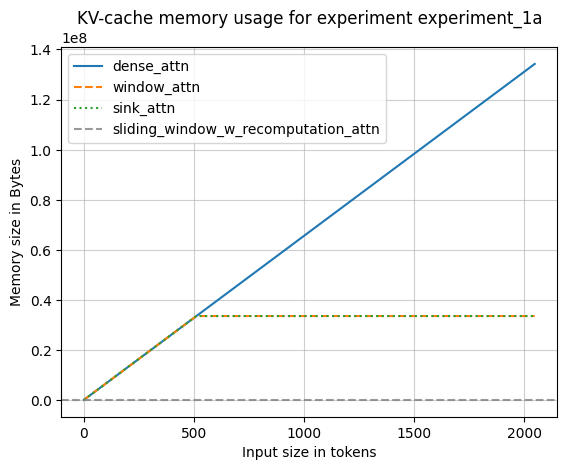

In [24]:
show_memory_usage(results_1a)

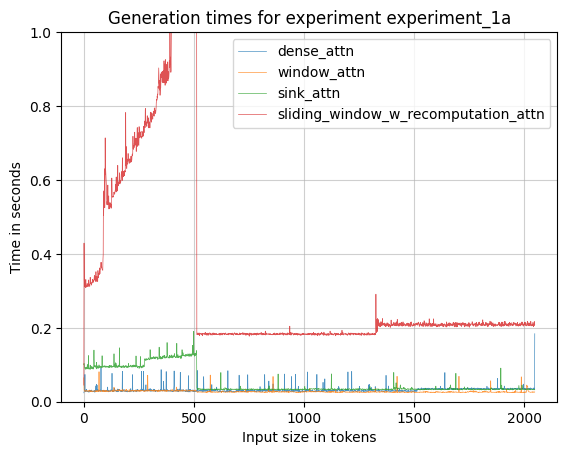

In [25]:
show_generation_times(results_1a)

In [22]:
show_statistics(results_1a)

NameError: name 'results_1a' is not defined

#### Investigating the number of attention sinks

In [36]:
experiment_1b_config = {
    "name": "experiment_1b",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA3_MODEL_PATH,
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
        {
            "name": "1-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 1,
        },
        {
            "name": "2-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 2,
        },
        {
            "name": "3-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 3,
        },
        {
            "name": "4-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "name": "10-sink_attn",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 10,
        },
    ],
}

In [37]:
results_1b = run_attention_experiment(load_data(), experiment_1b_config)

Running the following global configuration:('experiment_1c', '/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'attn_impl': 'dense_attn', 'kv_cache_size': -1, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.17, ppl: 1.18: 100%|██████████| 2048/2048 [02:07<00:00, 16.08it/s]       


Running the following run configuration:{'attn_impl': 'sliding_window_w_recomputation_attn', 'kv_cache_size': 512, 'recompute': True}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.26, ppl: 1.30: 100%|██████████| 2048/2048 [15:19<00:00,  2.23it/s]        


Running the following run configuration:{'name': '1-sink_attn', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 1}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:55<00:00, 17.71it/s]        


Running the following run configuration:{'name': '2-sink_attn', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 2}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:50<00:00, 18.51it/s]       


Running the following run configuration:{'name': '3-sink_attn', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 3}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:52<00:00, 18.28it/s]       


Running the following run configuration:{'name': '4-sink_attn', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:50<00:00, 18.58it/s]       


Running the following run configuration:{'name': '10-sink_attn', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 10}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.20: 100%|██████████| 2048/2048 [01:50<00:00, 18.47it/s]       


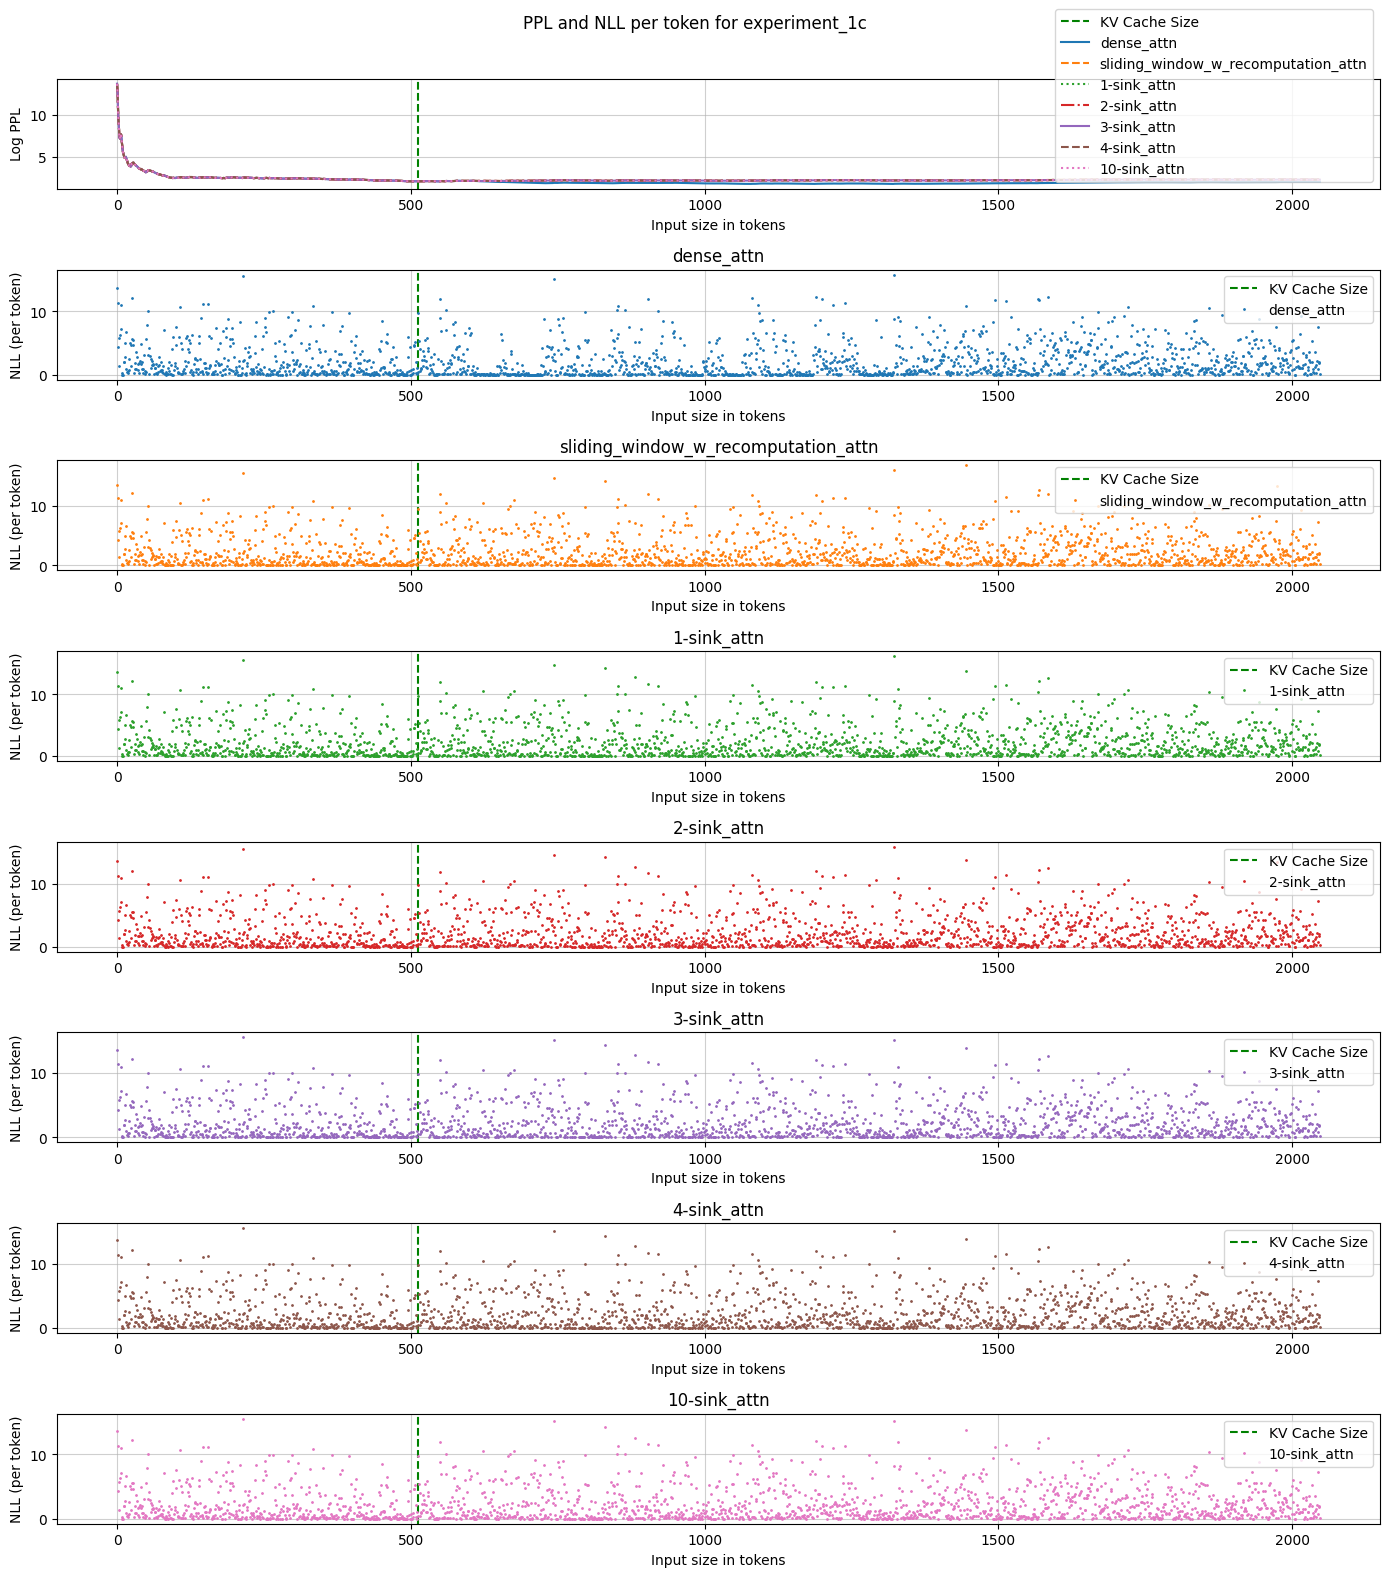

In [51]:
show_nlls(results_1b, kv_size_line=512, context_length_line=0)

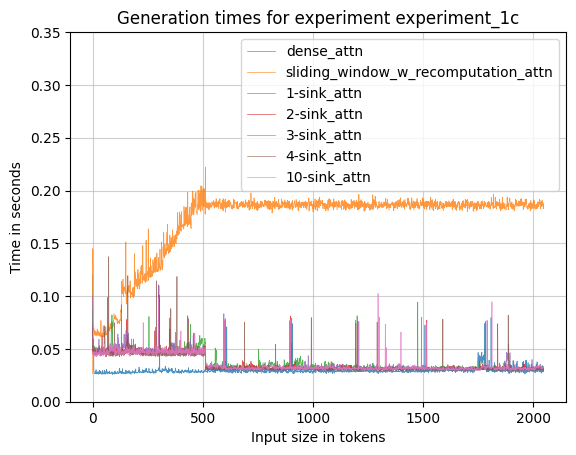

In [37]:
show_generation_times(results_1b, 0.35)

In [52]:
show_statistics(results_1b)

Name                             dense_attn sliding_window_w_recomputation_attn     1-sink_attn     2-sink_attn     3-sink_attn     4-sink_attn    10-sink_attn
Generation Time (mean ±std)  0.0296 ±0.0043                      0.1711 ±0.0339  0.0368 ±0.0086  0.0358 ±0.0079  0.0362 ±0.0084  0.0353 ±0.0084  0.0360 ±0.0078
Max Memory Usage [MB]                 128.0                                 0.0            32.0            32.0            32.0            32.0            32.0
PPL                                    7.22                                9.52            9.49            9.49            9.45            9.43            9.37
PPL @ 10                           260.9045                            260.9047        260.9045        260.9045        260.9045        260.9045        260.9045
PPL @ 256                           11.4795                             11.4795         11.4795         11.4795         11.4795         11.4795         11.4795
PPL @ 512                            7.7

#### Decoding sequences longer then model's context window

Llama3.2-1B has a context window of 131,072. Decoding such long sequences without production optimisations requires significant time. In this work, we focus on and explore the phenomenon of sink attention rather than measure streaming performance, hence we will demonstrate model performance when decoding sequences longer than the training context using LLama2-7B. Crucially, this means we won't show sink attention because it is impossible to implement for GPT2, due to the use of absolute positional encodings added to token embeddings. 

LLama2-7B was trained on sequences of maximally 4096 tokens, hence we will test how attention implementation perform on sequences up to 6000 tokens.

In [19]:
experiment_1c_config = {
    "name": "experiment_1c",
    "num_passes": 1,
    "chunk_len": 6000,
    "model": LLAMA2_MODEL_PATH,
    "runs": [
        {
            "attn_impl": "dense_attn",
            "kv_cache_size": -1,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "attn_impl": "sliding_window_w_recomputation_attn",
            "kv_cache_size": 512,
            "recompute": True,
        },
    ],
}

In [ ]:
results_1c = run_attention_experiment(load_data(), experiment_1c_config)

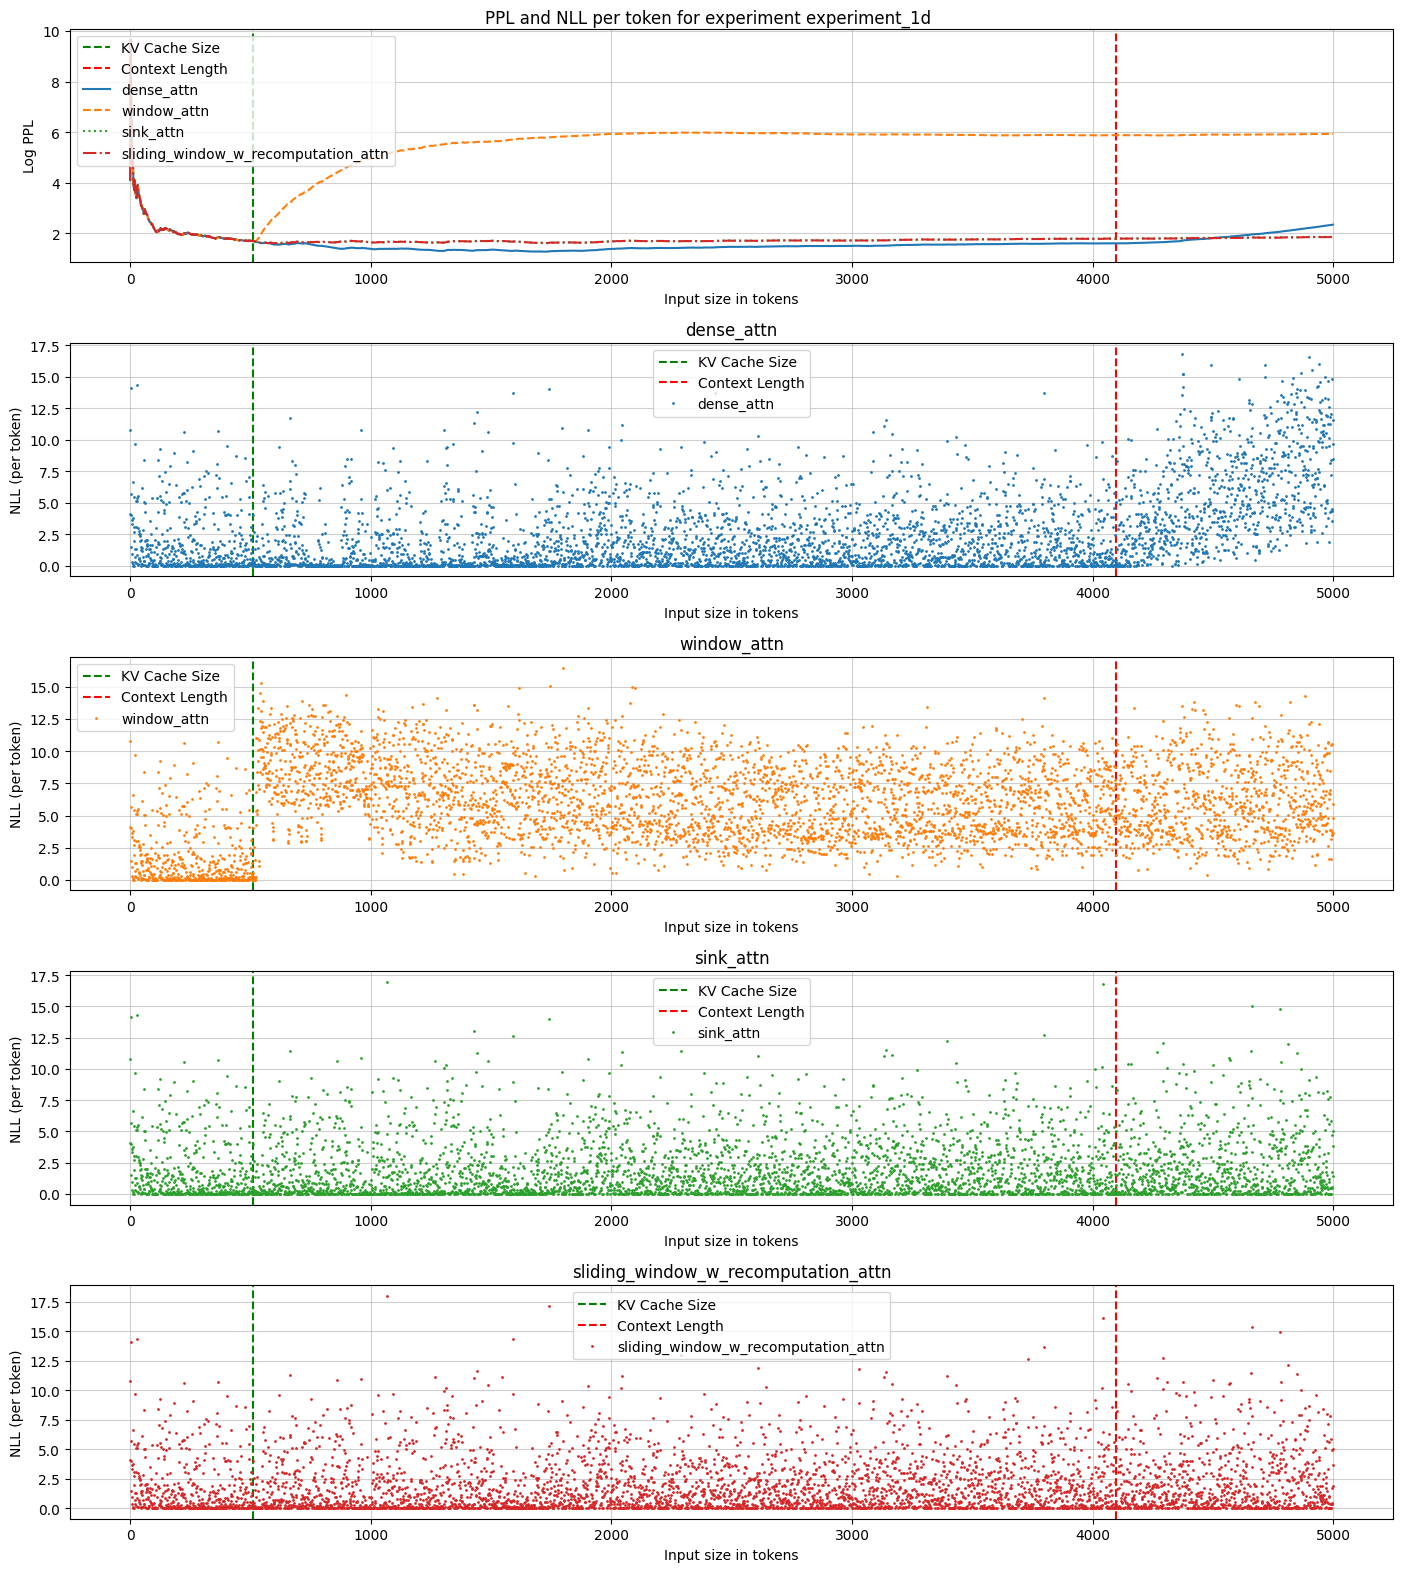

In [17]:
show_nlls(results_1c, kv_size_line=512, context_length_line=4096)

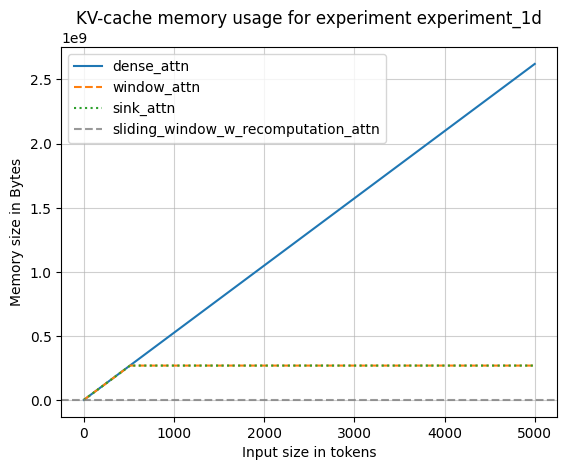

In [18]:
show_memory_usage(results_1c)

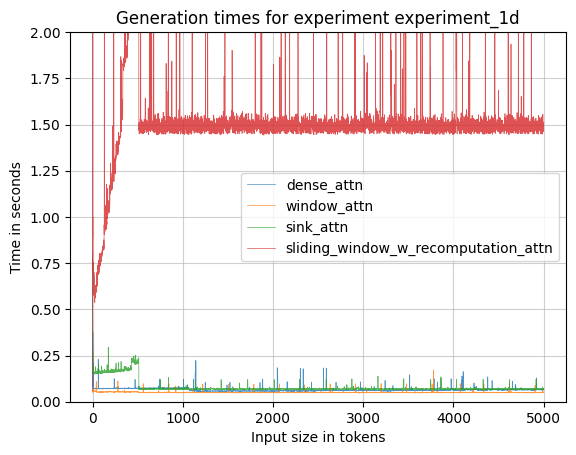

In [ ]:
show_generation_times(results_1c, 2)

In [30]:
show_statistics(results_1c, [10, 256, 512, 513, 768, 1024, 2048, 4096, 4900])

Name                         dense_attn window_attn   sink_attn sliding_window_w_recomputation_attn
Generation Time (mean ±std)  0.06 ±0.02  0.05 ±0.00  0.08 ±0.03                          1.54 ±0.42
Max Memory Usage [MB]            2500.0       256.0       256.0                                 0.0
PPL                               10.37      374.96        6.42                                6.36
PPL @ 10                       114.8351    114.8351    114.8045                            114.6721
PPL @ 256                        7.1362      7.1362      7.1374                              7.1345
PPL @ 512                        5.4076      5.4076      5.4085                              5.4068
PPL @ 513                        5.3918      5.3919      5.3927                              5.3913
PPL @ 768                        4.6008     49.6964      5.2153                              5.2017
PPL @ 1024                       3.9497    152.1311      5.1597                              5.1542


## Experiment 2

#TODO


2. The success of sink attention is based on two elements: 1) maintaining first n sink tokens, and 2) shifting positional encodings counting from 0 from the first sink token. 
	1. [ ] What if we do not shift the positional encodings but use n sink tokens?
		1. When the context length of a model is long, it should not hit the problem of overrunning the context length, and may be interesting to see the difference between the shifted PE and not.
	2. [ ] What if we only shift the positional encodings but do not use any sink tokens?
		1. Authors say that they experimented by changing the initial token id and that it does not matter for the sink effect, but retaining the initial token lowers PPL. Then, maybe it the position is the only thing that matters and is sufficient to change PEs.
		2. If shifting PEs doesn't work, then the sink location is not tied to the positional encoding. Then it is tied either to the token type (xiao et al. says no) or is invariant of that as well and is an outcome of the pre-training.
		3. Change the initial token value. 

### Using sink tokens without shifting positional encodings 

In [41]:
experiment_2a_config = {
    "name": "experiment_2a",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA3_MODEL_PATH,
    "runs": [
        {
            "name": "window attention (no sink tokens, no positional shift)",
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "name": "sink attention without positional shift",
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
        {
            "name": "sink attention with positional shift",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
    ],
}

In [42]:
results_2a = run_attention_experiment(load_data(), experiment_2a_config)

Running the following global configuration:('experiment_2a', '/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'name': 'window attention (no sink tokens, no positional shift)', 'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 6.61, ppl: 740.31: 100%|██████████| 2048/2048 [01:40<00:00, 20.46it/s]      


Running the following run configuration:{'name': 'sink attention without positional shift', 'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 5.64, ppl: 281.01: 100%|██████████| 2048/2048 [01:36<00:00, 21.22it/s]      


Running the following run configuration:{'name': 'sink attention with positional shift', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:49<00:00, 18.73it/s]       


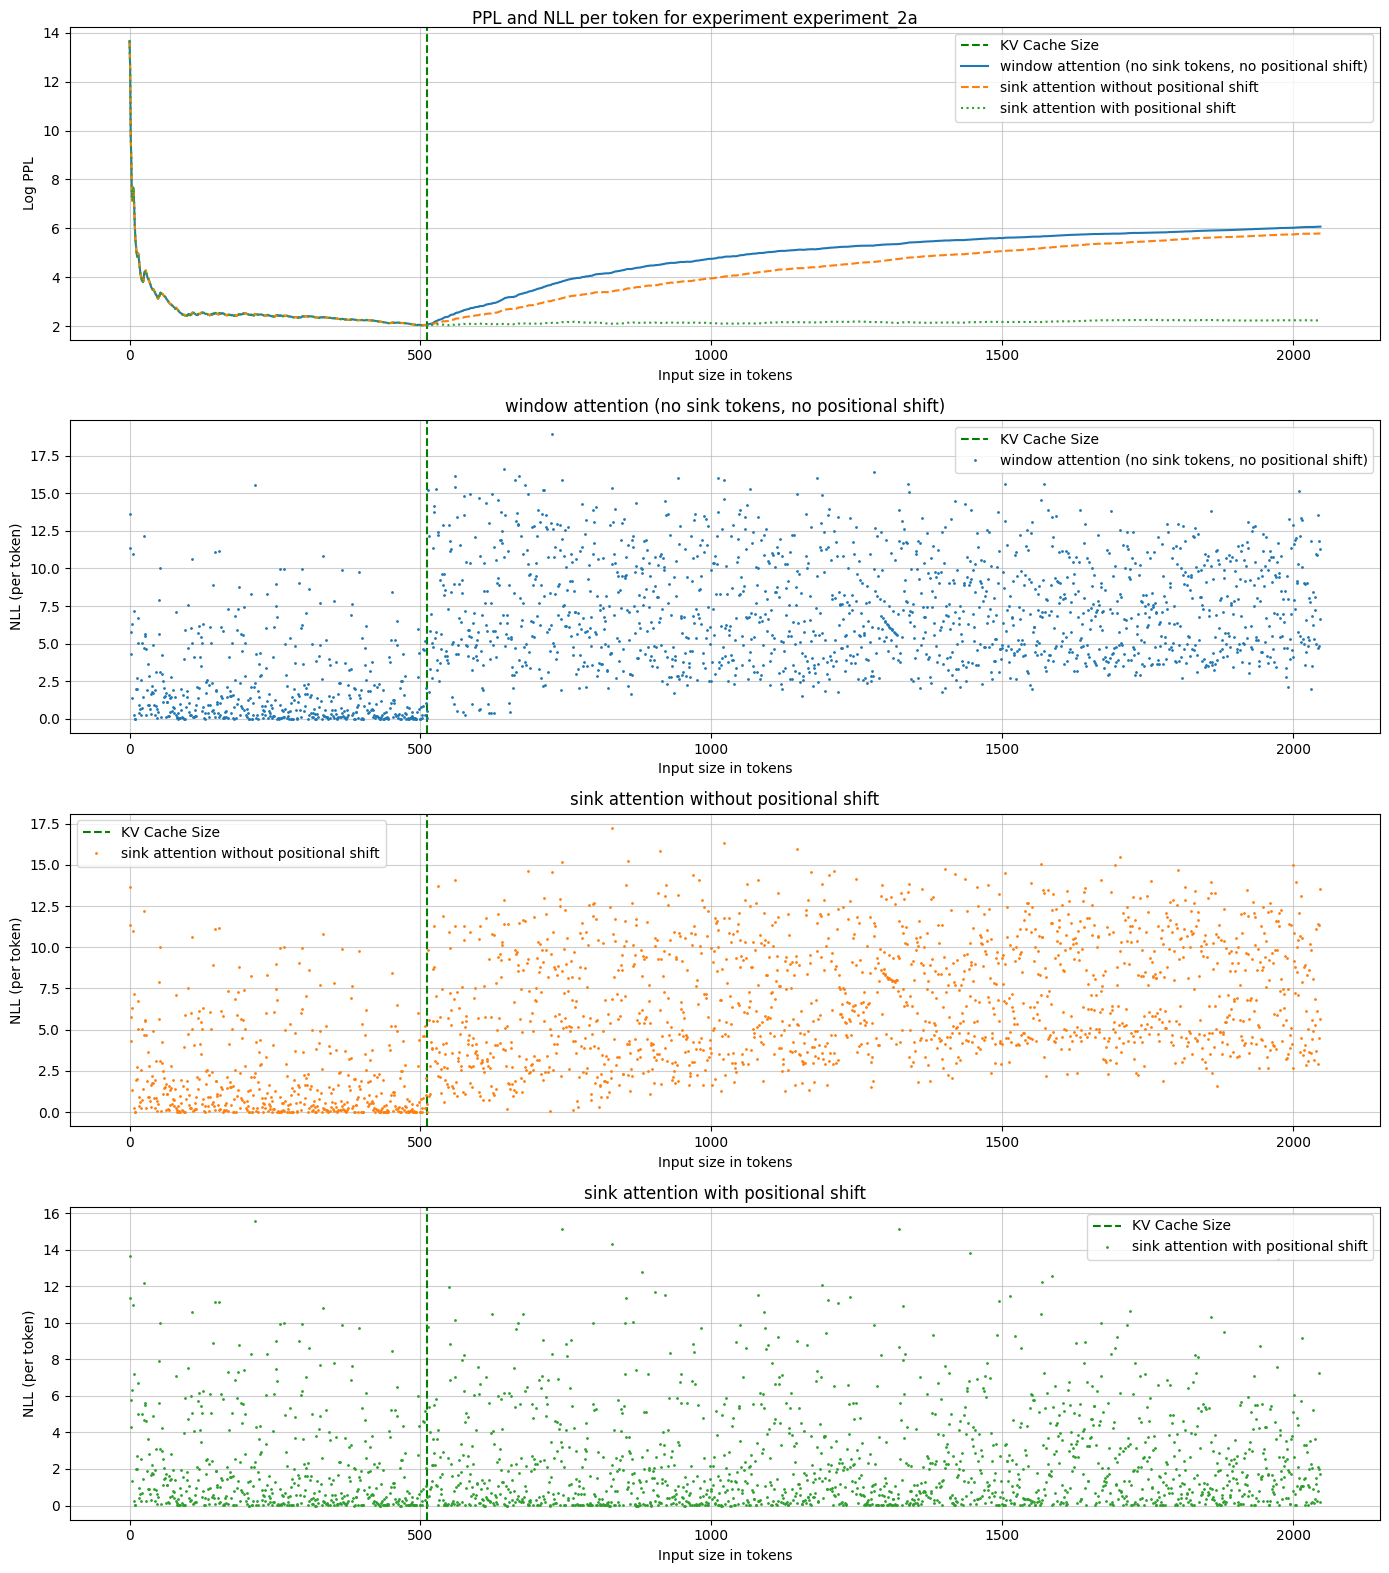

In [43]:
show_nlls(results_2a, kv_size_line=512, context_length_line=0)

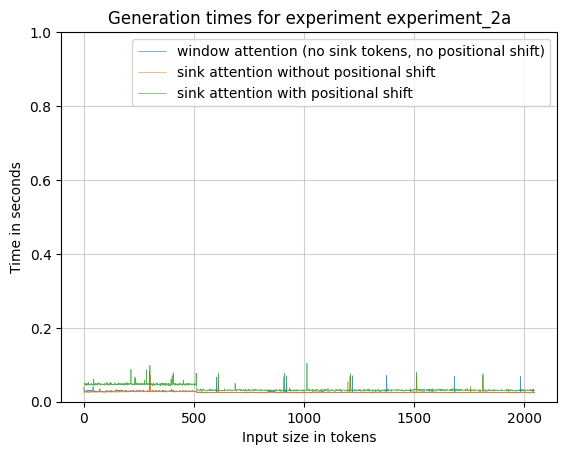

In [44]:
show_generation_times(results_2a)

In [54]:
show_statistics(results_2a)

Name                        window attention (no sink tokens, no positional shift) sink attention without positional shift sink attention with positional shift
Generation Time (mean ±std)                                         0.0262 ±0.0031                          0.0255 ±0.0028                       0.0355 ±0.0081
Max Memory Usage [MB]                                                         32.0                                    32.0                                 32.0
PPL                                                                         434.73                                  328.76                                 9.43
PPL @ 10                                                                  260.9045                                260.9045                             260.9045
PPL @ 256                                                                  11.4795                                 11.4795                              11.4795
PPL @ 512                               

### Where the attention sinks appear? 

It's clear now that the attention sink phenomenon is taking place and the first token (which is the `<bos>` token) gets a significant amount of the attention score. However, it's important to understand what makes this token the attention sink. The following experiments will further investigate if:
- the model have learnt to use positional encodings and always designates the first token (most distant to the new context) as the attention sink,
- is it possible that the model have remembered to always use the beginning of sequence `<bos>` token as its attention sink.

#### Shift positional encodings without using sink tokens - window attention with positional encoding shift

In [46]:
experiment_2b_config = {
    "name": "experiment_2b",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA3_MODEL_PATH,
    "runs": [
        {
            "name": "window attention (no sink tokens, no positional shift)",
            "attn_impl": "window_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "name": "window attention with positional shift",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 0,
        },
        {
            "name": "sink attention with positional shift",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 4,
        },
    ],
}

In [47]:
results_2b = run_attention_experiment(load_data(), experiment_2b_config)

Running the following global configuration:('experiment_2b', '/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'name': 'window attention (no sink tokens, no positional shift)', 'attn_impl': 'window_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 6.61, ppl: 740.31: 100%|██████████| 2048/2048 [01:38<00:00, 20.72it/s]      


Running the following run configuration:{'name': 'window attention with positional shift', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 0}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 1.04, ppl: 2.83: 100%|██████████| 2048/2048 [01:51<00:00, 18.44it/s]        


Running the following run configuration:{'name': 'sink attention with positional shift', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 4}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:49<00:00, 18.64it/s]       


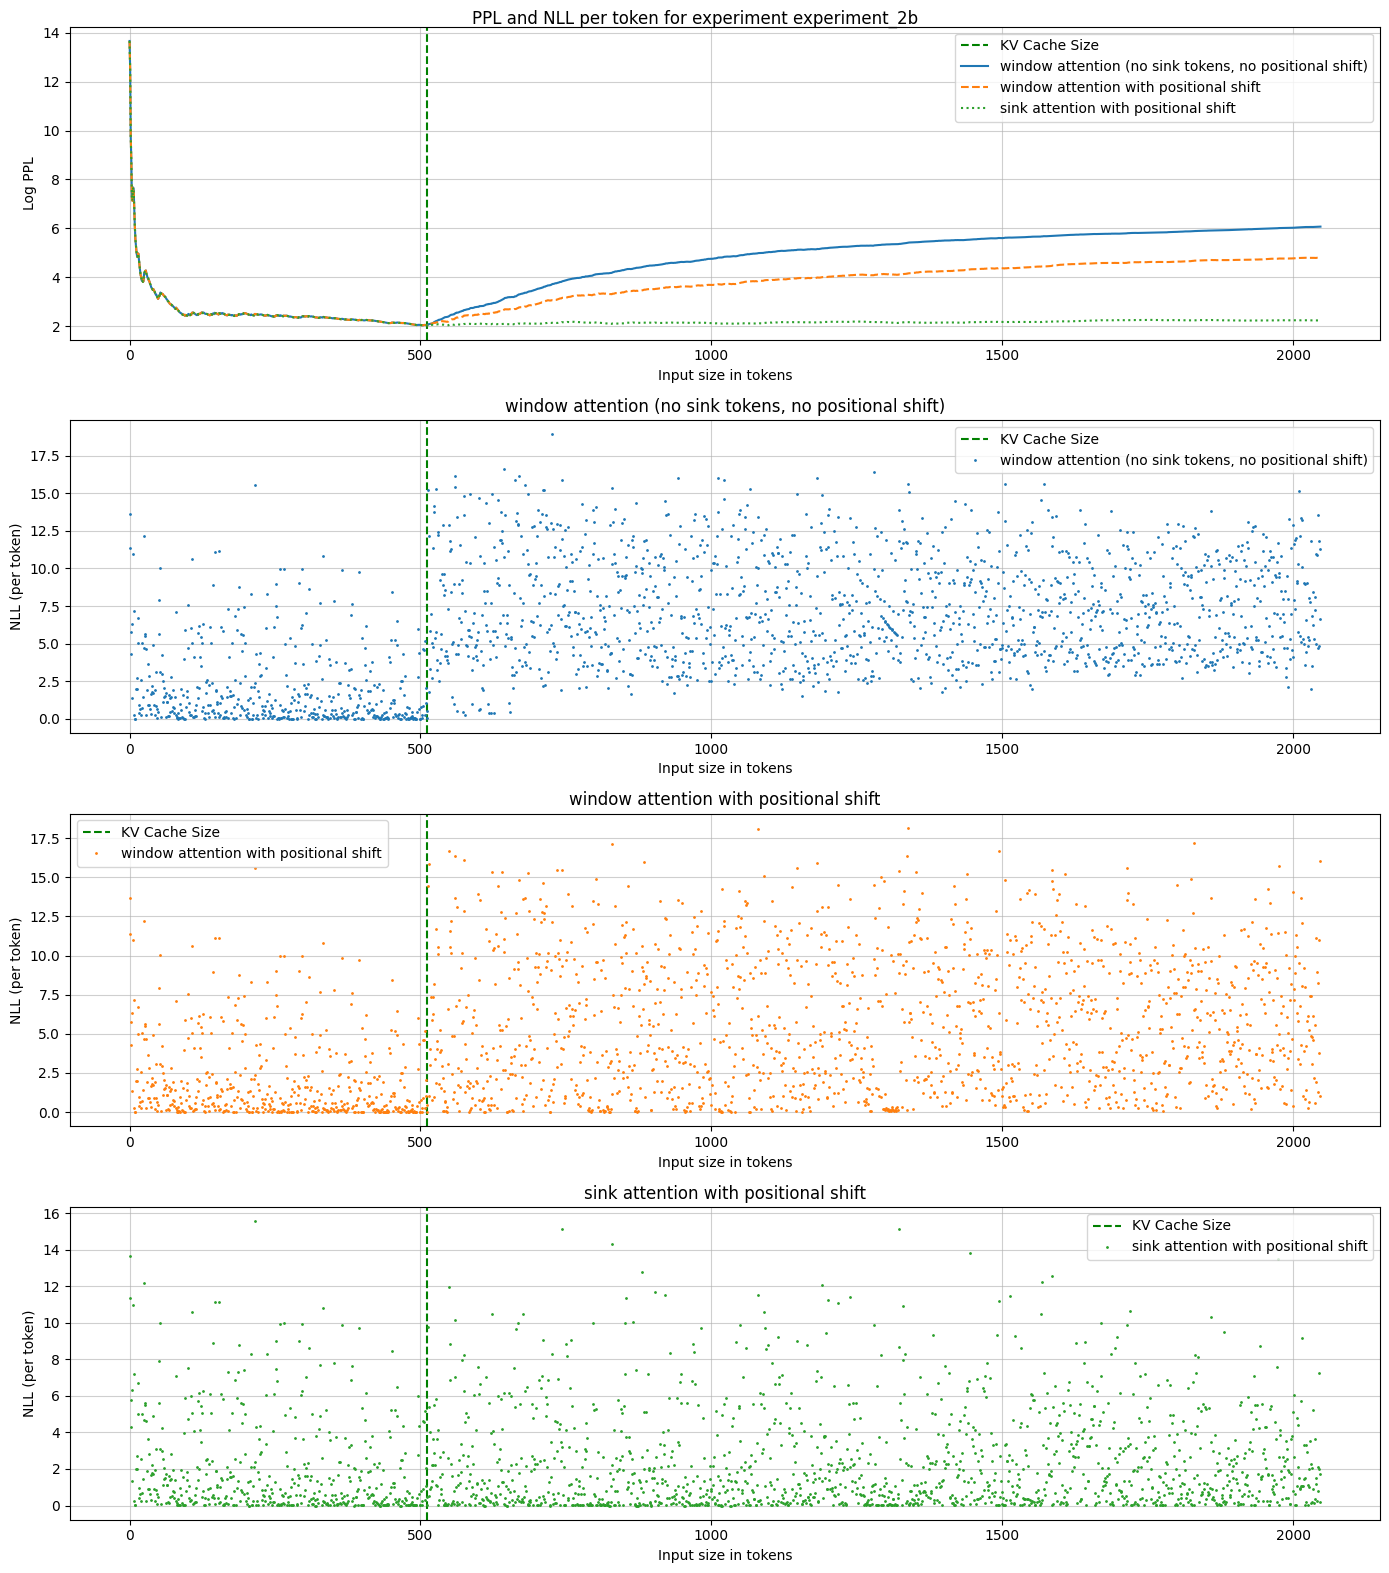

In [48]:
show_nlls(results_2b, kv_size_line=512, context_length_line=0)

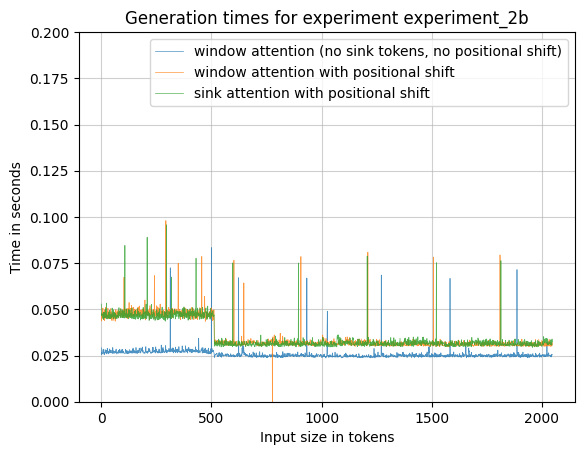

In [49]:
show_generation_times(results_2b, 0.2)

In [56]:
show_statistics(results_2b)

Name                        window attention (no sink tokens, no positional shift) window attention with positional shift sink attention with positional shift
Generation Time (mean ±std)                                         0.0257 ±0.0030                         0.0356 ±0.0080                       0.0355 ±0.0075
Max Memory Usage [MB]                                                         32.0                                   32.0                                 32.0
PPL                                                                         434.73                                 122.34                                 9.43
PPL @ 10                                                                  260.9045                               260.9045                             260.9045
PPL @ 256                                                                  11.4795                                11.4795                              11.4795
PPL @ 512                                     



#### Is `<bos>` designated to become an attention sink? - sink attention with removed <bos> token

In [51]:
experiment_2c_config = {
    "name": "experiment_2c",
    "num_passes": 1,
    "chunk_len": 2048,
    "model": LLAMA3_MODEL_PATH,
    "runs": [
        {
            "name": "1-sink attention with removed bos token",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 1,
            "remove_bos_token": True,
        },
        {
            "name": "1-sink attention",
            "attn_impl": "sink_attn",
            "kv_cache_size": 512,
            "sink_attn_tks": 1,
        },
    ],
}

In [52]:
results_2c = run_attention_experiment(load_data(), experiment_2c_config)

Running the following global configuration:('experiment_2c', '/Users/aszab/repos/models/Llama-3.2-1B', 1, 2048, 1)
Running the following run configuration:{'name': '1-sink attention with removed bos token', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 1, 'remove_bos_token': True}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.01, ppl: 1.01: 100%|██████████| 2048/2048 [01:52<00:00, 18.23it/s]        


Running the following run configuration:{'name': '1-sink attention', 'attn_impl': 'sink_attn', 'kv_cache_size': 512, 'sink_attn_tks': 1}


Token indices sequence length is longer than the specified maximum sequence length for this model (288937 > 131072). Running this sequence through the model will result in indexing errors


chunk_len: 2048
begin_idx=0, end_idx=2048


nll: 0.19, ppl: 1.21: 100%|██████████| 2048/2048 [01:52<00:00, 18.28it/s]        


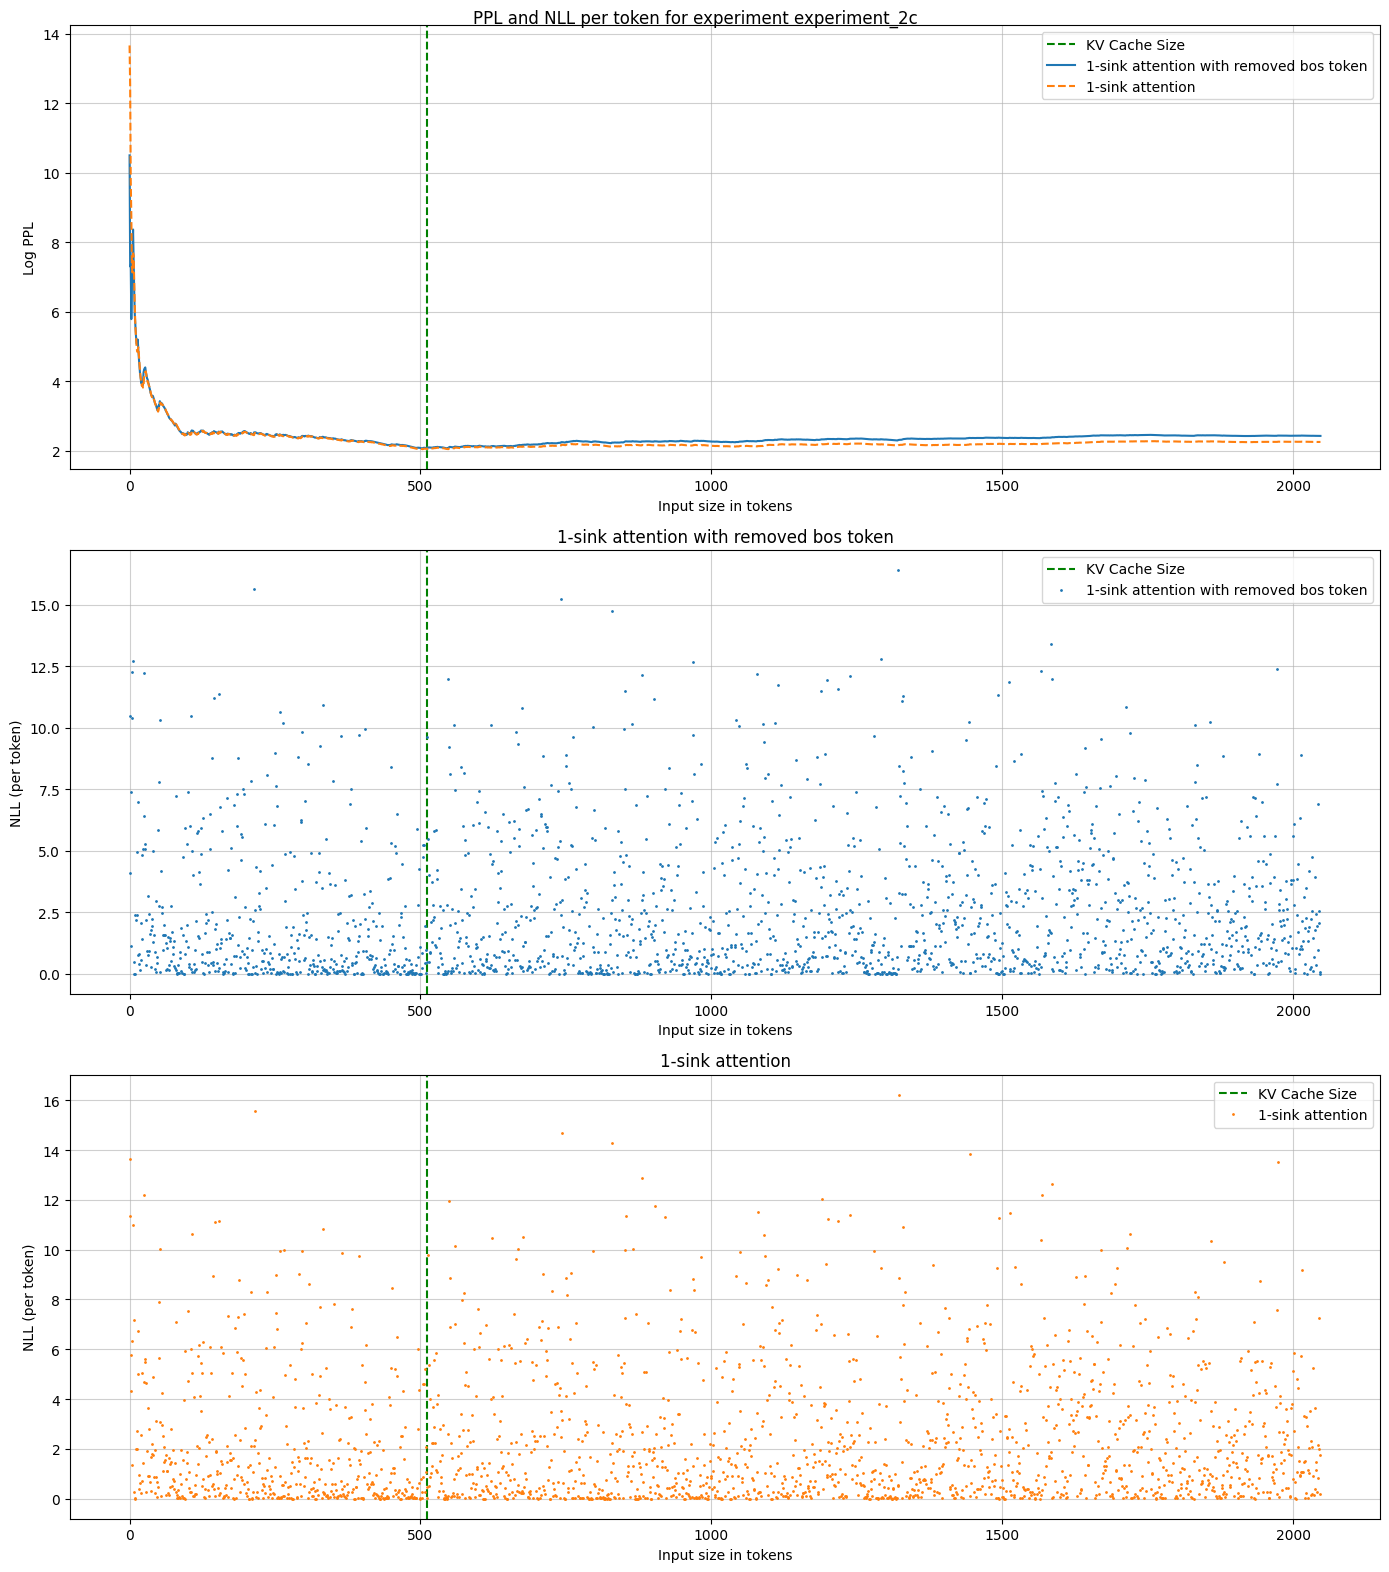

In [53]:
show_nlls(results_2c, kv_size_line=512, context_length_line=0)

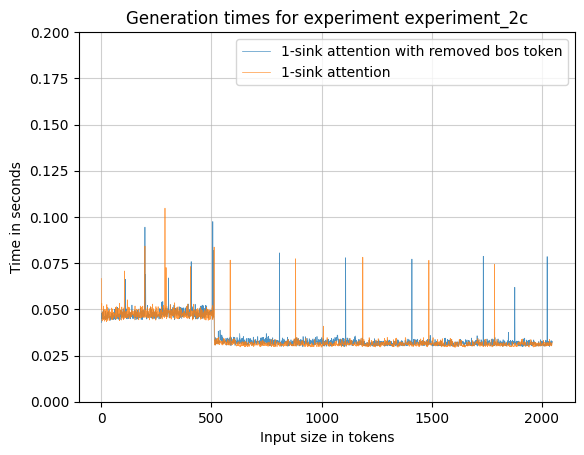

In [54]:
show_generation_times(results_2c, 0.2)

In [58]:
show_statistics(results_2c)

Name                        1-sink attention with removed bos token 1-sink attention
Generation Time (mean ±std)                          0.0360 ±0.0077   0.0355 ±0.0079
Max Memory Usage [MB]                                          32.0             32.0
PPL                                                           11.29             9.49
PPL @ 10                                                   265.6746         260.9045
PPL @ 256                                                   11.5161          11.4795
PPL @ 512                                                    8.0477           7.7431
PPL @ 513                                                     8.101           7.8606
PPL @ 768                                                    9.8079           8.9042
PPL @ 1024                                                   9.5268           8.3722
PPL @ 1536                                                  10.6587           8.9557


## Experiment 3

#TODO

Since PEs do not influence the sink location and they are also invariant of the token ids, they must occur as a result of pre-training. Now, there are papers, that explain their phenomenon and show that attention sinks are closely related to massive activations. In fact, sink locations are dictated not just by the first token position in training but also other tokens that bear low semantic meaning. This series of experiments investigates it. 

- [ ] Show the curves across decoder layers and attn heads for a test sequence

Since some publications claim that these attentions sink tokens are essentially repurposed tokens to serve as (implicit) attention biases,
1. [ ] how to identify them, and
2. [ ] does their presence or the lack of their presence influence the PPL/reasoning benchmarks?
It has been shown that adding a learnable key-value explicitly to each attention head can remove the massive activations and (partially) resolve the attention sink phenomenon. Since this study avoids training or re-training models, 
1. [ ] we can see if synthetically injecting tokens with low-semantic value, can help the model with better balancing of the attention score and potentially increase its reasoning capability (using some benchmarks) through the use of these tokens as some sort of registers.

### Visualising the attention sinks

In [26]:
def get_attn_map(
    attn: tuple[torch.Tensor],
    layer_num: int,
    head_num: int,
    remove_first_token: bool = False,
) -> np.ndarray:
    """
    Retrieves the attention map for a specified layer and head from the model's attention outputs.

    Args:
        attn (tuple[torch.Tensor]): A tuple of attention tensors from the model's output.attentions.
        layer_num (int): The index of the layer from which to retrieve the attention map.
                         If -1, the attention maps across all layers are averaged.
        head_num (int): The index of the head from which to retrieve the attention map.
                        If -1, the attention maps across all heads are averaged.

    Returns:
        np.ndarray: The attention map for the specified layer and head.
    """
    attn = torch.stack(attn).cpu().detach().numpy()
    if layer_num == -1:
        attn = attn.mean(axis=0, keepdims=True)
        layer_num = 0

    if head_num == -1:
        attn = attn.mean(axis=2, keepdims=True)
        head_num = 0

    attn_map = attn[layer_num, 0, head_num, :, :]
    if remove_first_token:
        attn_map = attn_map[1:, 1:]

    return attn_map

In [27]:
def show_attn(
    attn_map: np.ndarray,
    token_labels: Optional[list[str]] = None,
    log_scale: bool = False,
) -> None:
    """
    Visualizes an attention map with token labels.

    Parameters:
        attn_map (np.ndarray): The attention map to visualize. It is expected to be a 2D array.
        token_labels (list[str]): A list of token labels corresponding to the attention map.
        log_scale (bool, optional): If True, applies a logarithmic scale to the attention map values. Defaults to False.

    Returns:
        None
    """
    _, ax = plt.subplots(figsize=(8, 8))

    # mask for plotting the bad color for padding tokens (upper triangular part)
    attn_map = np.ma.masked_where(attn_map == 0, attn_map)

    cmap = plt.cm.coolwarm
    cmap.set_bad(color="grey")
    ax.matshow(np.log(attn_map) if log_scale else attn_map, cmap=cmap)

    ax.xaxis.set_label_position("bottom")  # Move x-axis label to the bottom
    ax.xaxis.tick_bottom()  # Ensure ticks are on the bottom
    if token_labels is not None:
        _ = ax.set_xticks(
            range(len(token_labels)),
            token_labels,
            fontsize=9,
            rotation=90,
        )
        _ = ax.set_yticks(
            range(len(token_labels)),
            token_labels,
            fontsize=9,
        )
    ax.set_ylabel("Query token", fontsize=12)
    ax.set_xlabel("Key token", fontsize=12)

In [33]:
llama3_model, llama3_tokenizer = load_model_tokenizer(
    LLAMA3_MODEL_PATH,
    attn_implementation="eager",
    output_attn=True,
    output_hidden_states=True,
)
NUM_LAYERS = llama3_model.config.num_hidden_layers
NUM_HEADS = llama3_model.config.num_attention_heads

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [111]:
prompt = "Hello, my dog is cute and playful, although my cat isn't."
inputs = llama3_tokenizer(
    prompt,
    return_tensors="pt",
).to(device)

with torch.no_grad():
    outputs = llama3_model(
        **inputs,
    )

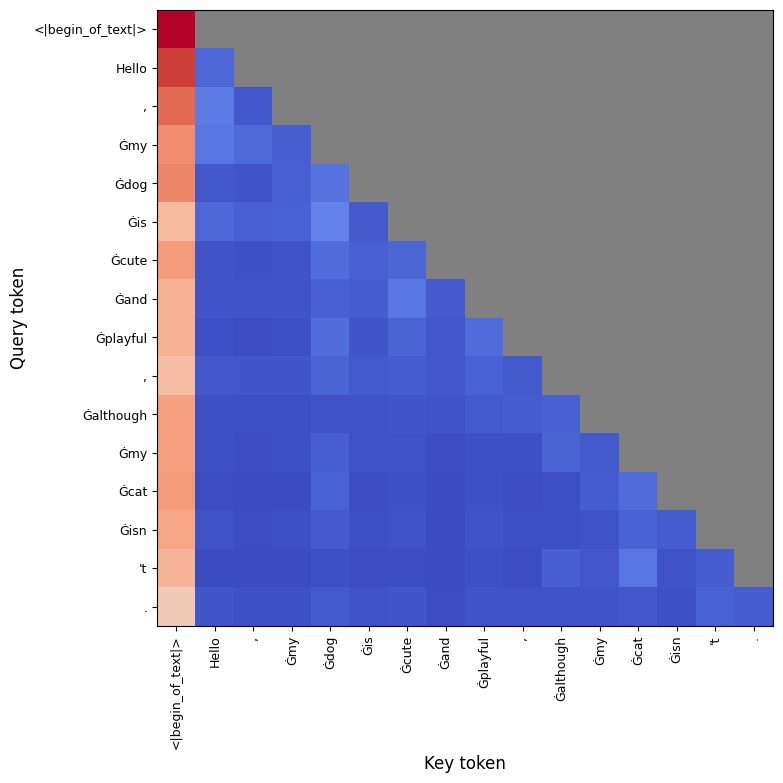

In [112]:
show_attn(
    get_attn_map(
        outputs.attentions,
        3,
        -1,
    ),
    llama3_tokenizer.convert_ids_to_tokens(
        inputs["input_ids"].cpu().detach().numpy()[0]
    ),
)

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/881408162.py:24: RuntimeWarning: divide by zero encountered in log
  ax.matshow(np.log(attn_map) if log_scale else attn_map, cmap=cmap)


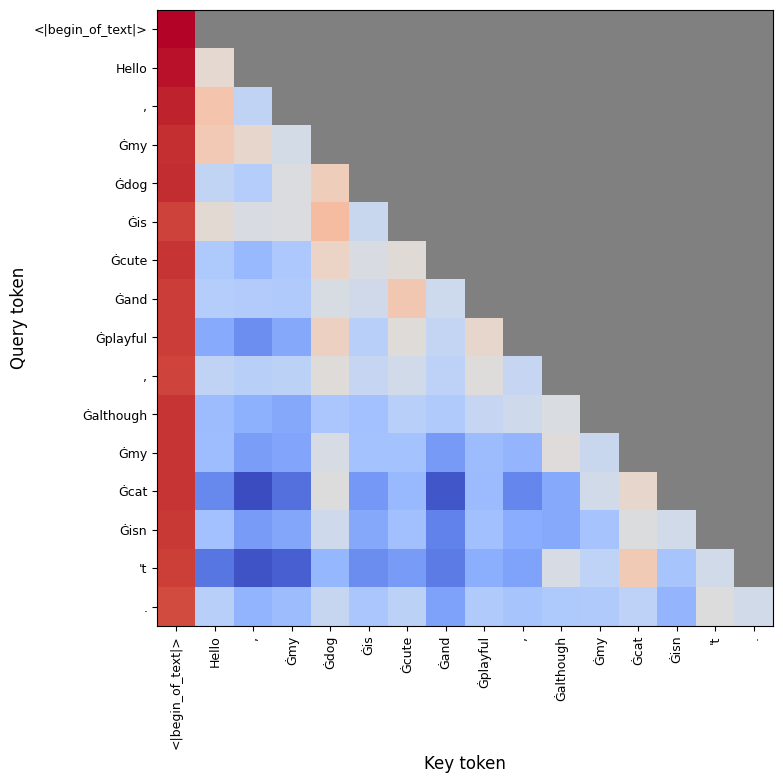

In [113]:
show_attn(
    get_attn_map(
        outputs.attentions,
        3,
        -1,
    ),
    llama3_tokenizer.convert_ids_to_tokens(
        inputs["input_ids"].cpu().detach().numpy()[0]
    ),
    log_scale=True,
)

In [28]:
def show_attn_layers(attn_map_lst: list[np.ndarray], log_scale: bool = False) -> None:
    """
    Visualizes attention maps for each layer in a grid layout.

    Parameters:
        attn_map_lst (list[np.ndarray]): A list of attention maps, where each attention map is a 2D numpy array.
        log_scale (bool): If True, applies a logarithmic scale to the attention maps for visualization. Default is False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    n_cols = 4
    n_rows = len(attn_map_lst) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 10))

    for i, attn_map in enumerate(attn_map_lst):
        # mask for plotting the bad color for padding tokens (upper triangular part)
        attn_map = np.ma.masked_where(attn_map == 0, attn_map)

        cmap = plt.cm.coolwarm
        cmap.set_bad(color="grey")
        axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)

        axs[i // n_cols][i % n_cols].xaxis.set_label_position(
            "bottom"
        )  # Move x-axis label to the bottom
        axs[i // n_cols][
            i % n_cols
        ].xaxis.tick_bottom()  # Ensure ticks are on the bottom

        axs[i // n_cols][i % n_cols].set_title(f"Layer {i}")
        axs[i // n_cols][i % n_cols].set_ylabel("Query token", fontsize=10)
        axs[i // n_cols][i % n_cols].set_xlabel("Key token", fontsize=10)
        fig.tight_layout()

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_32097/2761506107.py:24: RuntimeWarning: divide by zero encountered in log
  axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)


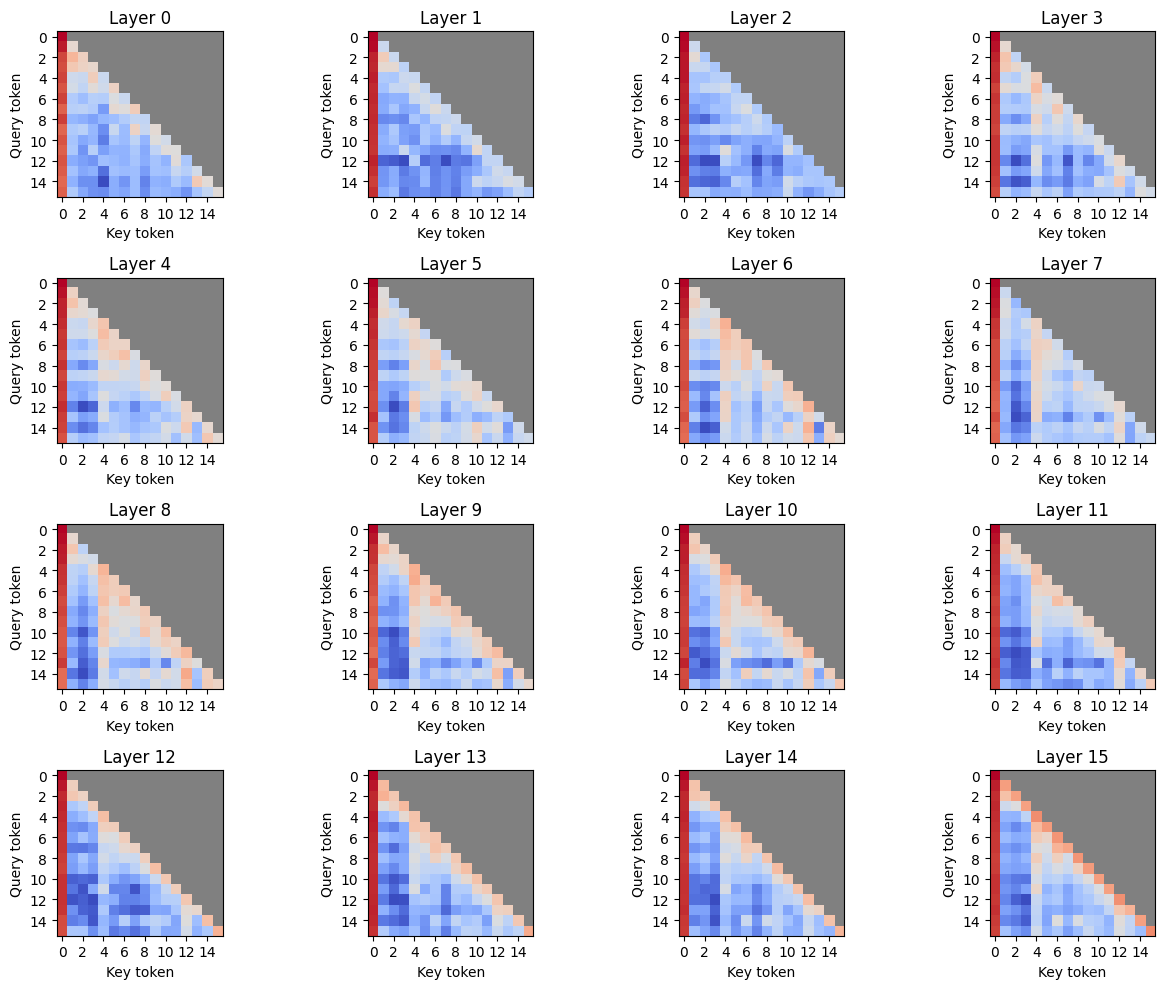

In [ ]:
show_attn_layers(
    [get_attn_map(outputs.attentions, i, -1) for i in range(16)], log_scale=True
)

### How much attention is "wasted" in a sink?

Text(0, 0.5, 'Propotion of attention given to the first token')

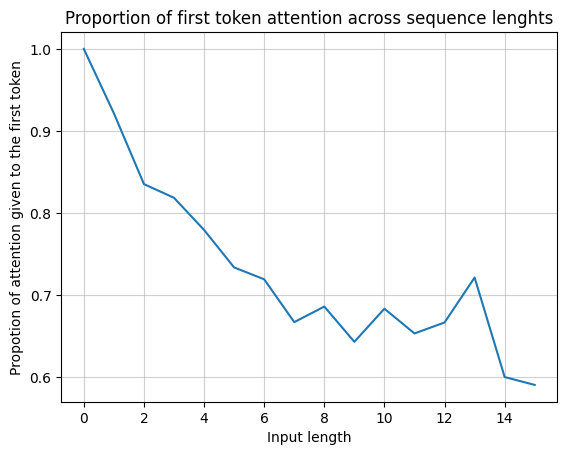

In [215]:
attn_map = get_attn_map(outputs.attentions, -1, -1)
plt.plot(range(attn_map.shape[1]), attn_map[:, 0])
plt.grid(zorder=1, alpha=0.6)
plt.title("Proportion of first token attention across sequence lenghts")
plt.xlabel("Input length")
plt.ylabel("Propotion of attention given to the first token")

In [29]:
def get_mean_attention_outputs(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizerBase,
    num_samples: int = 1,
    sample_length: int = 1024,
    custom_bos_token: Optional[str] = None,
):
    encodings = tokenizer(load_data(), return_tensors="pt").to(device)
    assert num_samples * sample_length <= encodings.input_ids.size(1)

    attention_outputs = [
        torch.zeros(1, NUM_HEADS, sample_length, sample_length).to(device)
        for _ in range(NUM_LAYERS)
    ]
    if custom_bos_token is None:
        custom_bos_token = tokenizer.bos_token

    for idx in tqdm(range(num_samples)):
        with torch.no_grad():

            inputs = encodings.input_ids[
                :, 1 + idx * sample_length : 1 + (idx + 1) * sample_length
            ]

            # make sure the first token is always the bos token
            inputs = torch.cat(
                [
                    torch.LongTensor(
                        [[llama3_tokenizer(custom_bos_token).input_ids[-1]]]
                    ).to(device),
                    inputs[:, :-1],
                ],
                dim=1,
            )

            outputs = model(inputs)

        # accumulate mean
        for block_id in range(NUM_LAYERS):
            attention_outputs[block_id] += outputs.attentions[block_id] / num_samples

        if torch.backends.mps.is_available():
            torch.mps.empty_cache()
    return attention_outputs

In [21]:
normal_attention_outputs_100 = get_mean_attention_outputs(
    llama3_model, llama3_tokenizer, 100, 1024
)

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [115]:
normal_attention_outputs_1 = get_mean_attention_outputs(
    llama3_model, llama3_tokenizer, 1, 1024
)

Token indices sequence length is longer than the specified maximum sequence length for this model (274479 > 131072). Running this sequence through the model will result in indexing errors
100%|██████████| 1/1 [00:11<00:00, 11.93s/it]


In [30]:
def show_first_token_proportion(attention_outputs: list[torch.Tensor]) -> None:
    n_cols = 4
    n_rows = NUM_LAYERS // n_cols

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

    for layer_id in range(NUM_LAYERS):
        for head_id in range(NUM_HEADS):
            attn_map = get_attn_map(attention_outputs, layer_id, head_id)
            ax[layer_id // n_cols][layer_id % n_cols].plot(
                range(attn_map.shape[1]), attn_map[:, 0], linewidth=0.5, label=head_id
            )
        ax[layer_id // n_cols][layer_id % n_cols].set_title(f"Layer {layer_id}")
        ax[layer_id // n_cols][layer_id % n_cols].set_xlabel("Input length in tokens")
        ax[layer_id // n_cols][layer_id % n_cols].set_ylabel(
            "Proportion of attention given to the first token"
        )
        ax[layer_id // n_cols][layer_id % n_cols].set_ylim(-0.05, 1.05)
        ax[layer_id // n_cols][layer_id % n_cols].grid(zorder=1, alpha=0.6)

    fig.suptitle(
        "Proportion of first token attention\n across transformer heads. Averaged over 100 sequences."
    )
    fig.tight_layout()
    fig.legend(labels=list(range(NUM_HEADS)), loc="upper right")

In [31]:
def show_attention_distribution_over_context(
    attention_outputs: list[torch.Tensor],
) -> None:
    n_cols = 4
    n_rows = NUM_LAYERS // n_cols

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

    for layer_id in range(NUM_LAYERS):
        attn_map = get_attn_map(attention_outputs, layer_id, -1)
        ax[layer_id // n_cols][layer_id % n_cols].plot(
            range(attn_map.shape[1]), attn_map[-1, :], linewidth=0.6
        )
        ax[layer_id // n_cols][layer_id % n_cols].axhline(
            0.5, color="r", linestyle="--"
        )
        ax[layer_id // n_cols][layer_id % n_cols].set_yscale("log")

        ax[layer_id // n_cols][layer_id % n_cols].set_title(f"Layer {layer_id}")
        ax[layer_id // n_cols][layer_id % n_cols].set_xlabel("Position in the input")
        ax[layer_id // n_cols][layer_id % n_cols].set_ylabel("Attention score")
        ax[layer_id // n_cols][layer_id % n_cols].set_ylim(-0.05, 1.05)
        ax[layer_id // n_cols][layer_id % n_cols].grid(zorder=1, alpha=0.6)

    fig.suptitle(
        "Proportion of attention given given to each position in the context across layers.\nAveraged over sequences and attention heads. Red line indicates 50% attention score."
    )
    fig.tight_layout()

In [122]:
show_first_token_proportion(normal_attention_outputs_100)

NameError: name 'normal_attention_outputs_100' is not defined

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/771124280.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[layer_id // n_cols][layer_id % n_cols].set_ylim(-0.05, 1.05)


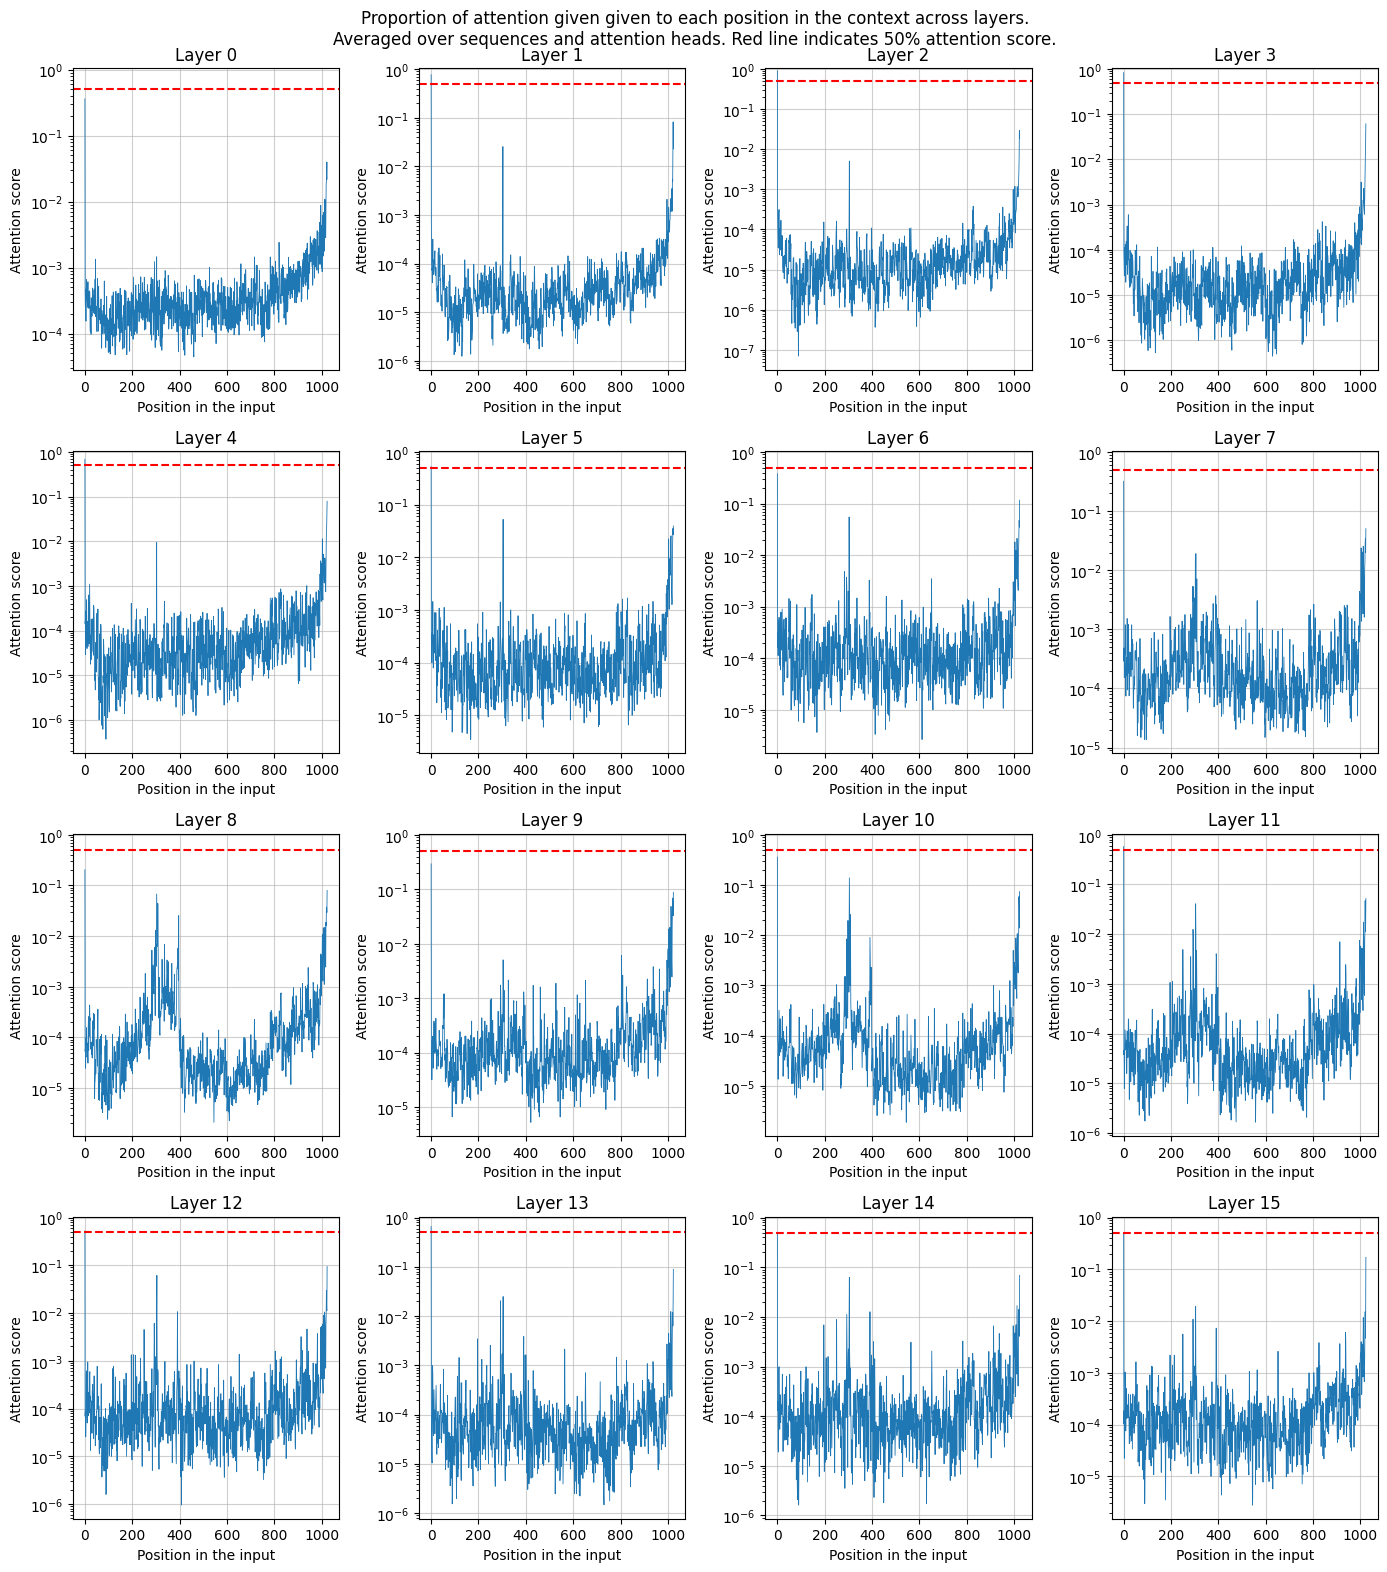

In [123]:
show_attention_distribution_over_context(normal_attention_outputs_1)

#### Where else is the attention dumped?

In [ ]:
llama2_model, llama2_tokenizer = load_model_tokenizer(
    LLAMA2_MODEL_PATH,
    attn_implementation="eager",
    output_attn=True,
    output_hidden_states=True,
)

In [230]:
# prompt = "We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely."
prompt = """The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English- to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data."""

inputs = llama3_tokenizer(
    prompt,
    return_tensors="pt",
).to(device)

with torch.no_grad():
    outputs = llama3_model(
        **inputs,
    )

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_16198/881408162.py:24: RuntimeWarning: divide by zero encountered in log
  ax.matshow(np.log(attn_map) if log_scale else attn_map, cmap=cmap)


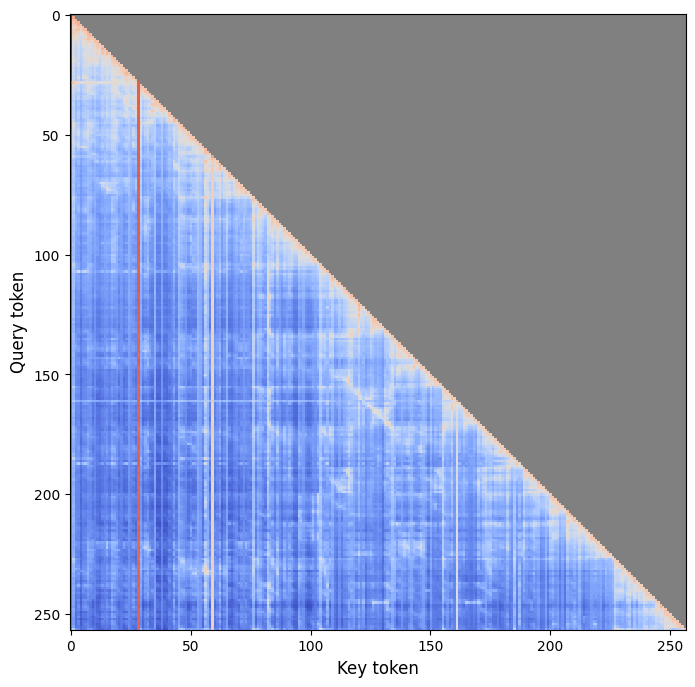

In [240]:
attn_map = get_attn_map(
    outputs.attentions,
    -1,
    -1,
)

show_attn(
    attn_map,
    log_scale=True,
)

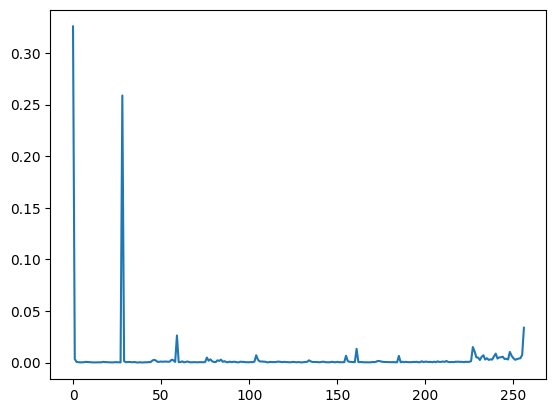

In [241]:
plt.plot(
    range(257),
    attn_map[-1, :],
)

In [246]:
inds = np.argpartition(attn_map[-1, :], -2)[-2:]
inds

array([28,  0])

In [250]:
for ind in inds:
    print(ind, llama3_tokenizer.convert_ids_to_tokens(inputs.input_ids[:, ind]))

28 ['.']
0 ['<s>']


#### Most frequently attended tokens

In [34]:
sample_length = 1024
num_passes = 100
top_k = 100

encodings = llama3_tokenizer(load_data(), return_tensors="pt")

top_tokens_dict = {}
top_token_attention_scores_dict = {}

for i in tqdm(range(num_passes)):
    inputs = encodings.input_ids[:, i * sample_length : (i + 1) * sample_length].to(
        device
    )

    # make sure the first token is always the bos token
    if inputs[0, 0] != llama3_tokenizer.bos_token_id:
        inputs = torch.cat(
            [
                torch.LongTensor([[llama3_tokenizer.bos_token_id]]).to(device),
                inputs[:, :-1],
            ],
            dim=1,
        )

    with torch.no_grad():
        outputs = llama3_model(inputs)

    attn_map = get_attn_map(outputs.attentions, -1, -1)

    ind_dict = {}
    num_tokens = attn_map.shape[1]

    # find top_k token positions with the highest attention scores
    for i in range(attn_map.shape[1] - top_k):
        ind = np.argpartition(attn_map[-1, : num_tokens - i], -top_k)[-top_k:]
        for idx in ind:
            ind_dict[idx] = ind_dict.get(idx, 0) + 1

    # update the global dictionary with token counts
    top_tokens_dict = {}
    for tkn_pos, tkn_count in ind_dict.items():
        tkn_id = inputs[:, tkn_pos].item()
        top_tokens_dict[tkn_id] = top_tokens_dict.get(tkn_id, 0) + tkn_count

        top_token_attention_scores_dict[tkn_id] = (
            top_token_attention_scores_dict.get(tkn_id, 0) + attn_map[-1, :][tkn_pos]
        )

    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

# normalise the dict by the number of passes
top_token_attention_scores_dict = {
    k: v / num_passes for k, v in top_token_attention_scores_dict.items()
}

Token indices sequence length is longer than the specified maximum sequence length for this model (274479 > 131072). Running this sequence through the model will result in indexing errors
100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


##### Mostly attended to (most attention score)

Text(0, 0.5, 'Average attention score')

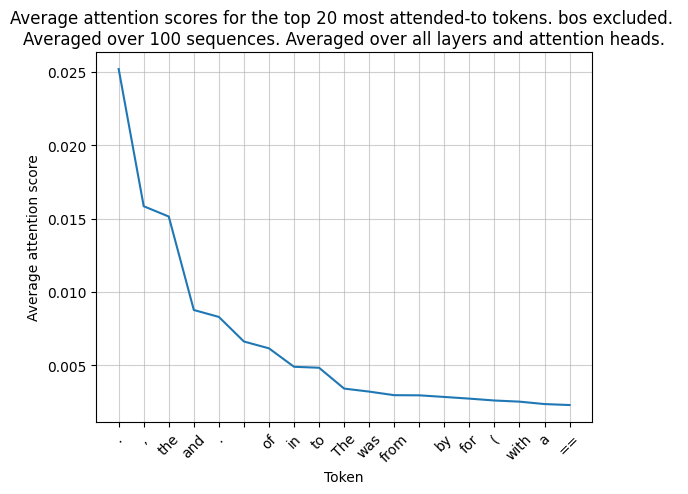

In [35]:
token_slice = slice(1, 20)  # take the first 20 but skip the bos token (initial sink).

# sort the dictionary by the avg attention scores
token_ids_lst, avg_attention_score_lst = zip(
    *sorted(top_token_attention_scores_dict.items(), key=lambda x: x[1], reverse=True)
)

plt.plot(range(len(token_ids_lst[token_slice])), avg_attention_score_lst[token_slice])
_ = plt.xticks(
    range(len(token_ids_lst[token_slice])),
    labels=[
        llama3_tokenizer.convert_ids_to_tokens([i])[0].replace("Ġ", "").replace("Ċ", "")
        for i in token_ids_lst[token_slice]
    ],
    rotation=45,
)
plt.grid(alpha=0.6, zorder=1)
plt.title(
    "Average attention scores for the top 20 most attended-to tokens. bos excluded. \nAveraged over 100 sequences. Averaged over all layers and attention heads."
)
plt.xlabel("Token")
plt.ylabel("Average attention score")

In [36]:
top_k_tokens = 20
top_attended_to_tokens = [
    llama3_tokenizer.convert_ids_to_tokens([i])[0].replace("Ġ", " ").replace("Ċ", "\n")
    for i in token_ids_lst[1:top_k_tokens]
]

In [38]:
list(zip(token_ids_lst[1:top_k_tokens], top_attended_to_tokens))

[(13, '.'),
 (11, ','),
 (279, ' the'),
 (323, ' and'),
 (4286, '.\n\n\n'),
 (220, ' '),
 (315, ' of'),
 (304, ' in'),
 (311, ' to'),
 (578, ' The'),
 (574, ' was'),
 (505, ' from'),
 (1432, '\n\n\n'),
 (555, ' by'),
 (369, ' for'),
 (320, ' ('),
 (449, ' with'),
 (264, ' a'),
 (624, ' ==')]

##### Most frequently attended (count-wise)

This aims to detect tokens which are consistently attended to (vertical bars on attention plots).

In [127]:
a = llama3_tokenizer.convert_ids_to_tokens(list(top_tokens_dict.keys())[:20])
[a.replace("Ġ", " ").replace("Ċ", "\n") for a in a]

[' A',
 'es',
 ' China',
 'Åį',
 'oud',
 '7',
 ' Philippine',
 ' it',
 ' Sea',
 ' country',
 ' shear',
 '.',
 ' Japan',
 ' development',
 ' east',
 ' south',
 ' west',
 'mass',
 ' Ty',
 ' land']

### Attention sinks and massive activations

Can we locate the same attention sink tokens through by detecting massive activations?

In [128]:
inputs = llama3_tokenizer("Hello! My name is John", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = llama3_model(
        **inputs,
    )

In [129]:
llama3_tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().detach().numpy()[0])

['<|begin_of_text|>', 'Hello', '!', 'ĠMy', 'Ġname', 'Ġis', 'ĠJohn']

In [131]:
def show_activations(
    hidden_states: tuple[torch.Tensor],
    tokenizer: PreTrainedTokenizerBase,
):
    ncols = 4
    nrows = NUM_LAYERS // ncols
    fig, ax = plt.subplots(
        nrows, ncols, figsize=(ncols * 4, nrows * 4), subplot_kw={"projection": "3d"}
    )

    for i in range(NUM_LAYERS):
        for word_num in range(hidden_states[i][0].shape[0]):

            ax[i // ncols][i % ncols].plot(
                [word_num for _ in range(hidden_states[i][0].shape[1])],
                range(hidden_states[i][0].shape[1]),
                hidden_states[i][0][word_num].cpu().numpy(),
                color="blue",
            )
        ax[i // ncols][i % ncols].set_xticks(range(hidden_states[i][0].shape[0]))
        ax[i // ncols][i % ncols].set_xlim(0, hidden_states[i][0].shape[0])
        ax[i // ncols][i % ncols].set_xticklabels(
            tokenizer.convert_ids_to_tokens(
                inputs["input_ids"].cpu().detach().numpy()[0]
            ),
            fontsize=6,
            rotation=30,
        )
        ax[i // ncols][i % ncols].set_zlabel("Hidden state value", fontsize=8)
        ax[i // ncols][i % ncols].set_ylabel("Hidden state dimension", fontsize=8)
        ax[i // ncols][i % ncols].set_title(f"Layer {i}")
    fig.tight_layout()
    fig.suptitle("Activation values for hidden states after each layer")

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/3884718877.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


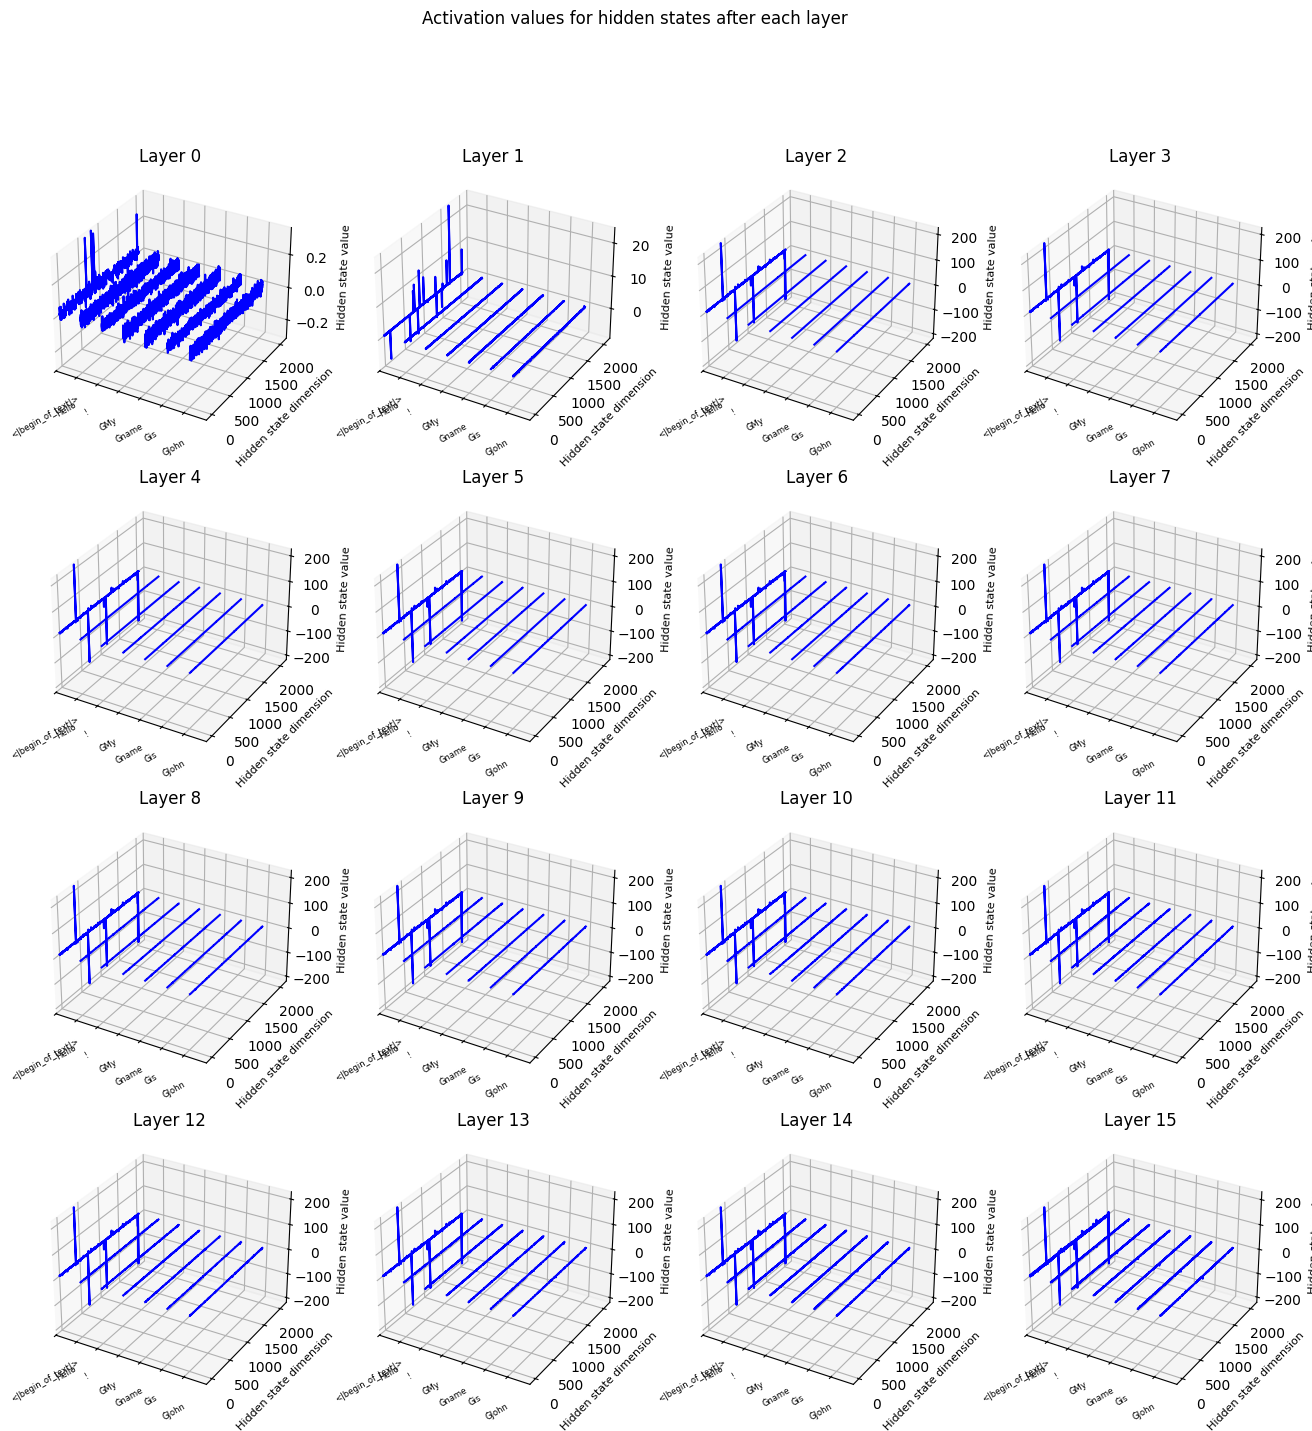

In [132]:
show_activations(outputs.hidden_states, llama3_tokenizer)

In [133]:
# display the median multiple for the initial word averaged over layers from the second.
def show_averaged_activations_per_word(
    hidden_states: tuple[torch.Tensor], word_num: int
):
    hs = torch.cat(hidden_states, 0).cpu().detach().numpy()
    layer_slice = slice(2, -2)  # exclude the first two layers and the final layer
    plt.plot(
        range(hs.shape[-1]),
        np.mean(
            np.abs(
                hs[layer_slice, word_num, :]
                / np.median(hs, axis=(1, 2)).reshape(-1, 1)[layer_slice]
            ),
            axis=0,
        ),
    )

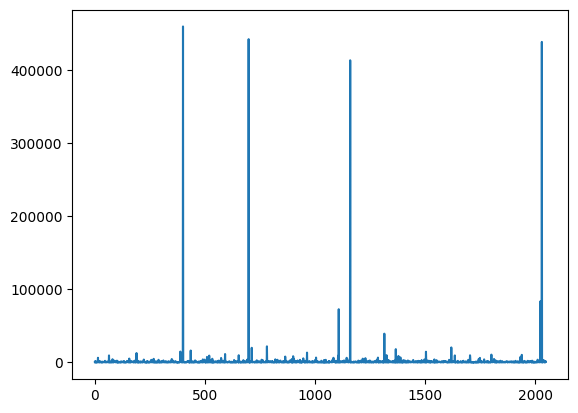

In [134]:
show_averaged_activations_per_word(outputs.hidden_states, word_num=0)

In [135]:
def find_massive_activations(hs: np.ndarray, threshold_multiple: int = 10e4) -> dict:
    """Finds word positions with massive activations in the hidden states.

    Args:
        hs (np.ndarray): The hidden states from the model output.
        threshold_multiple (int): The threshold multiple for the activation/median ratio.

    Returns:
        dict: A dictionary containing words with massive activations in the hidden states.
    """
    word_massive_activations = {}

    layer_slice = slice(2, -1)  # exclude the first two layers
    median = np.median(hs, axis=(1, 2)).reshape(-1, 1)[layer_slice]

    for word_pos in range(hs.shape[1]):
        mean_median_multiple = np.mean(
            np.abs(hs[layer_slice, word_pos, :] / median),
            axis=0,
        )

        idx = np.where(mean_median_multiple > threshold_multiple)[0]

        if len(idx) > 0:
            word_massive_activations[word_pos] = idx

    return word_massive_activations

In [136]:
find_massive_activations(torch.cat(outputs.hidden_states, 0).cpu().detach().numpy())

{0: array([ 400,  698, 1159, 2029])}

In [144]:
encodings = llama3_tokenizer(load_data(), return_tensors="pt").to(device)

num_samples = 10
sample_length = 1024
precede_with_bos = True

assert num_samples * sample_length <= encodings.input_ids.size(1)

massive_activation_token_position = []

for idx in tqdm(range(num_samples)):
    with torch.no_grad():
        inputs = encodings.input_ids[:, idx * sample_length : (idx + 1) * sample_length]

        if precede_with_bos:
            if inputs[0, 0] != llama3_tokenizer.bos_token_id:
                inputs = torch.cat(
                    [
                        torch.LongTensor([[llama3_tokenizer.bos_token_id]]).to(device),
                        inputs[:, :-1],
                    ],
                    dim=1,
                )

        outputs = llama3_model(inputs)

    ma_dict = find_massive_activations(
        torch.cat(outputs.hidden_states, 0).cpu().detach().numpy(), 50e4
    )

    for k in ma_dict:
        massive_activation_token_position.append(
            (
                k,
                llama3_tokenizer.decode(inputs[:, k]),
            )
        )

    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


In [145]:
massive_activation_token_position

[(0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>'),
 (0, '<|begin_of_text|>')]

### How the attention score is distributed when we remove the sink token?

In [22]:
no_bos_attention_outputs_100 = get_mean_attention_outputs(
    llama3_model, llama3_tokenizer, 100, 1024, custom_bos_token="\n"
)

100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


In [146]:
no_bos_attention_outputs_1 = get_mean_attention_outputs(
    llama3_model, llama3_tokenizer, 1, 1024, custom_bos_token="\n"
)

100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/771124280.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[layer_id // n_cols][layer_id % n_cols].set_ylim(-0.05, 1.05)


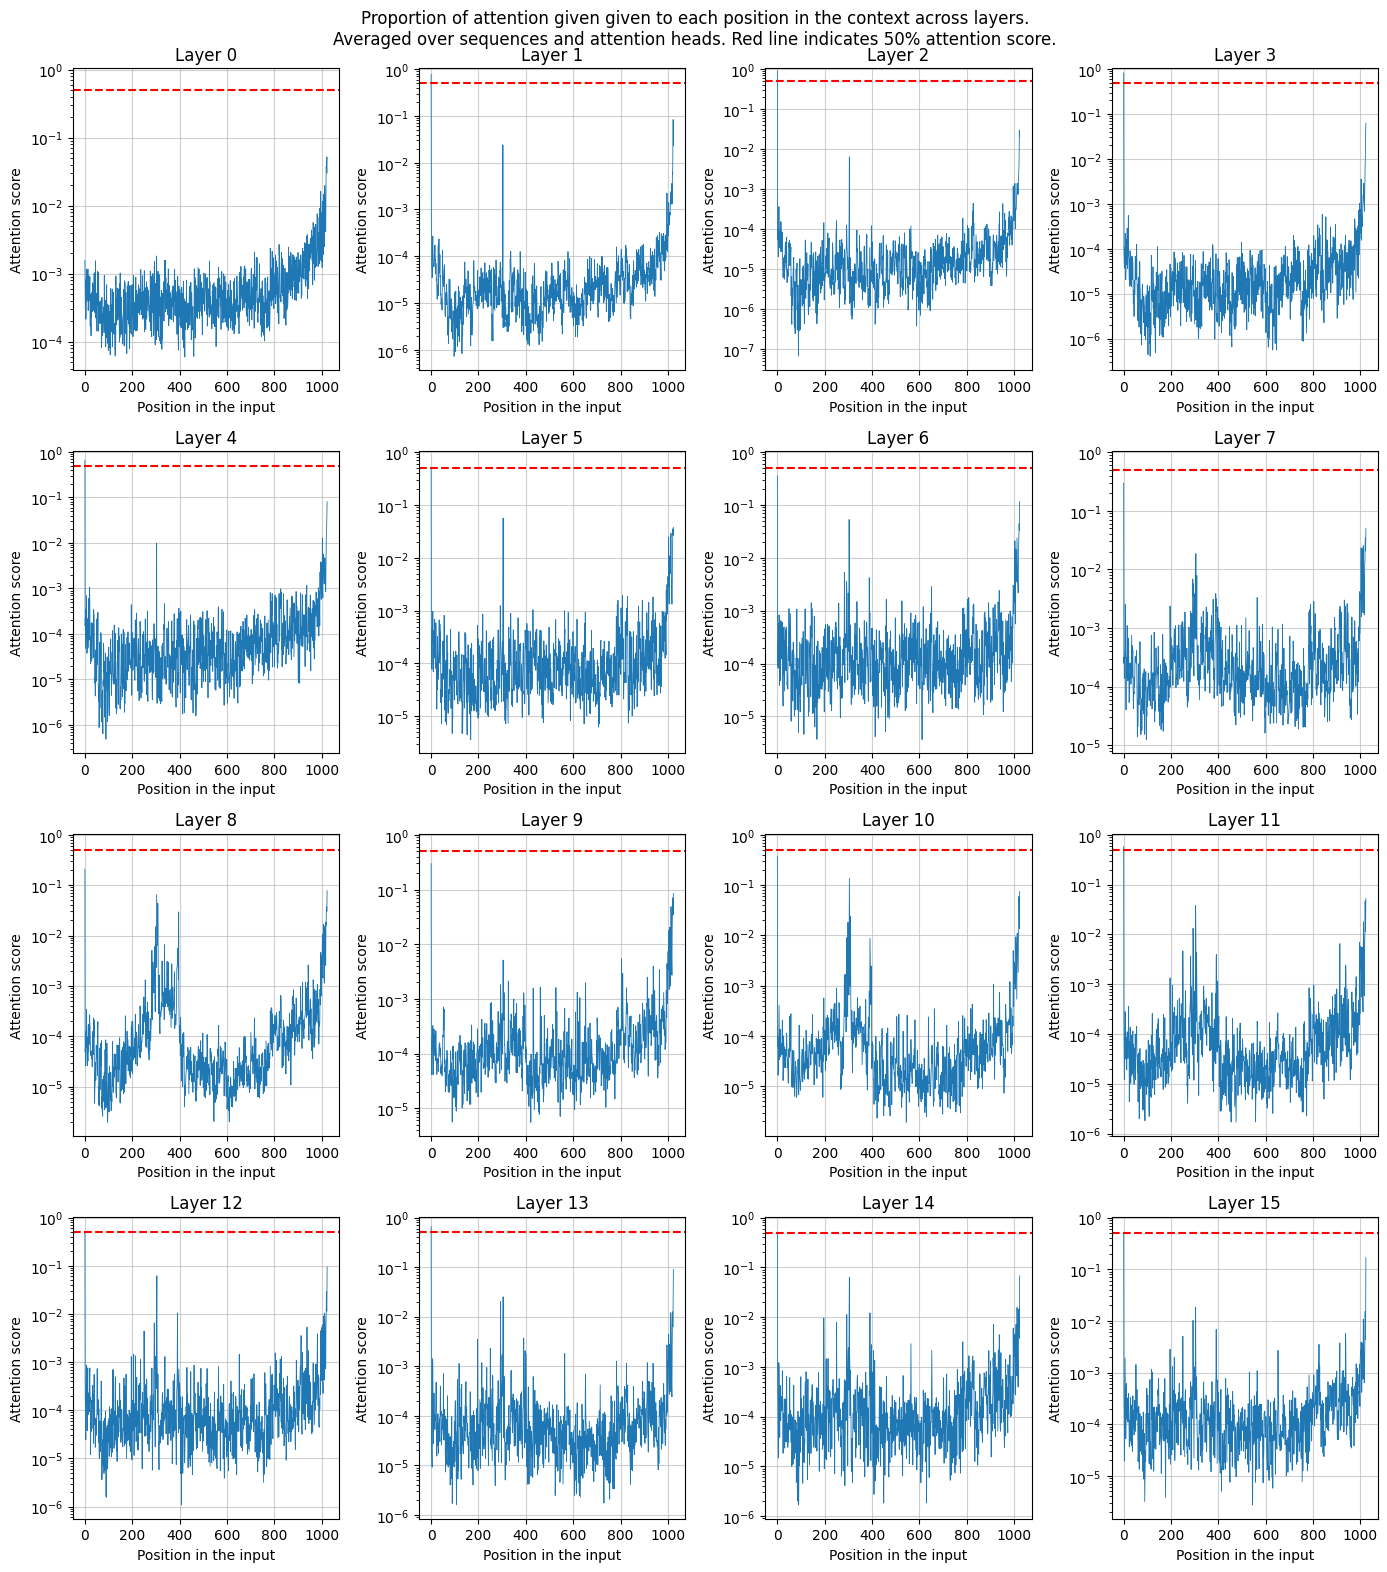

In [147]:
show_attention_distribution_over_context(no_bos_attention_outputs_1)

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/1596260846.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax[layer_id // n_cols][layer_id % n_cols].set_yticklabels(
/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/1596260846.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax[layer_id // n_cols][layer_id % n_cols].set_yticklabels(
/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/1596260846.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax[layer_id // n_cols][layer_id % n_cols].set_yticklabels(
/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_62930/1596260846.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. afte

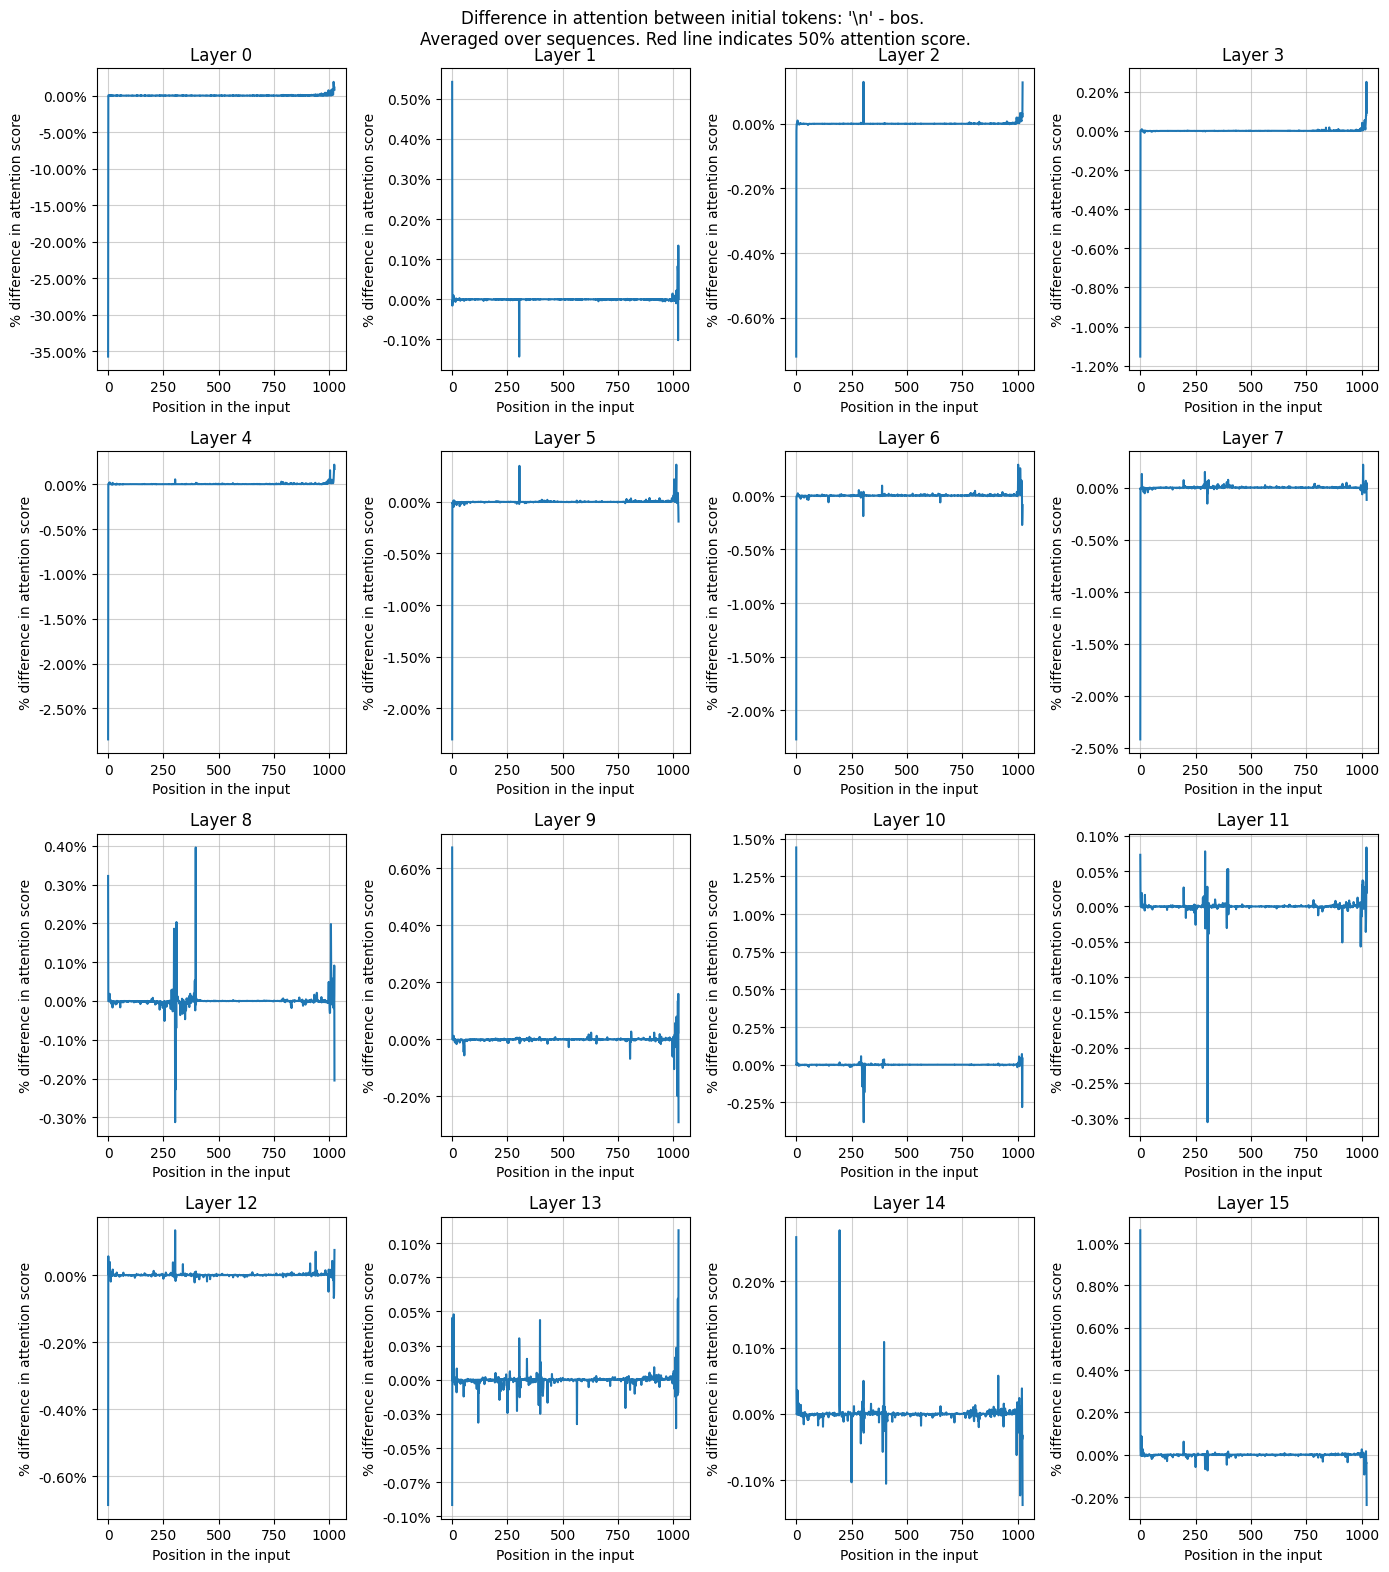

In [149]:
n_cols = 4
n_rows = NUM_LAYERS // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

for layer_id in range(NUM_LAYERS):
    attn_map1 = get_attn_map(normal_attention_outputs_1, layer_id, -1)
    attn_map2 = get_attn_map(no_bos_attention_outputs_1, layer_id, -1)
    ax[layer_id // n_cols][layer_id % n_cols].plot(
        range(attn_map.shape[1]), attn_map2[-1, :] - attn_map1[-1, :]
    )
    # ax[layer_id // n_cols][layer_id % n_cols].axhline(0.5, color="r", linestyle="--")
    # ax[layer_id // n_cols][layer_id % n_cols].set_yscale("log")

    ax[layer_id // n_cols][layer_id % n_cols].set_title(f"Layer {layer_id}")
    ax[layer_id // n_cols][layer_id % n_cols].set_xlabel("Position in the input")
    ax[layer_id // n_cols][layer_id % n_cols].set_ylabel(
        "% difference in attention score"
    )
    # ax[layer_id // n_cols][layer_id % n_cols].set_ylim(-0.05, 1.05)
    ax[layer_id // n_cols][layer_id % n_cols].grid(zorder=1, alpha=0.6)
    vals = ax[layer_id // n_cols][layer_id % n_cols].get_yticks()
    _ = ax[layer_id // n_cols][layer_id % n_cols].set_yticklabels(
        ["{:,.2%}".format(x) for x in vals]
    )

fig.suptitle(
    "Difference in attention between initial tokens: '\\n' - bos. \nAveraged over sequences. Red line indicates 50% attention score."
)
fig.tight_layout()

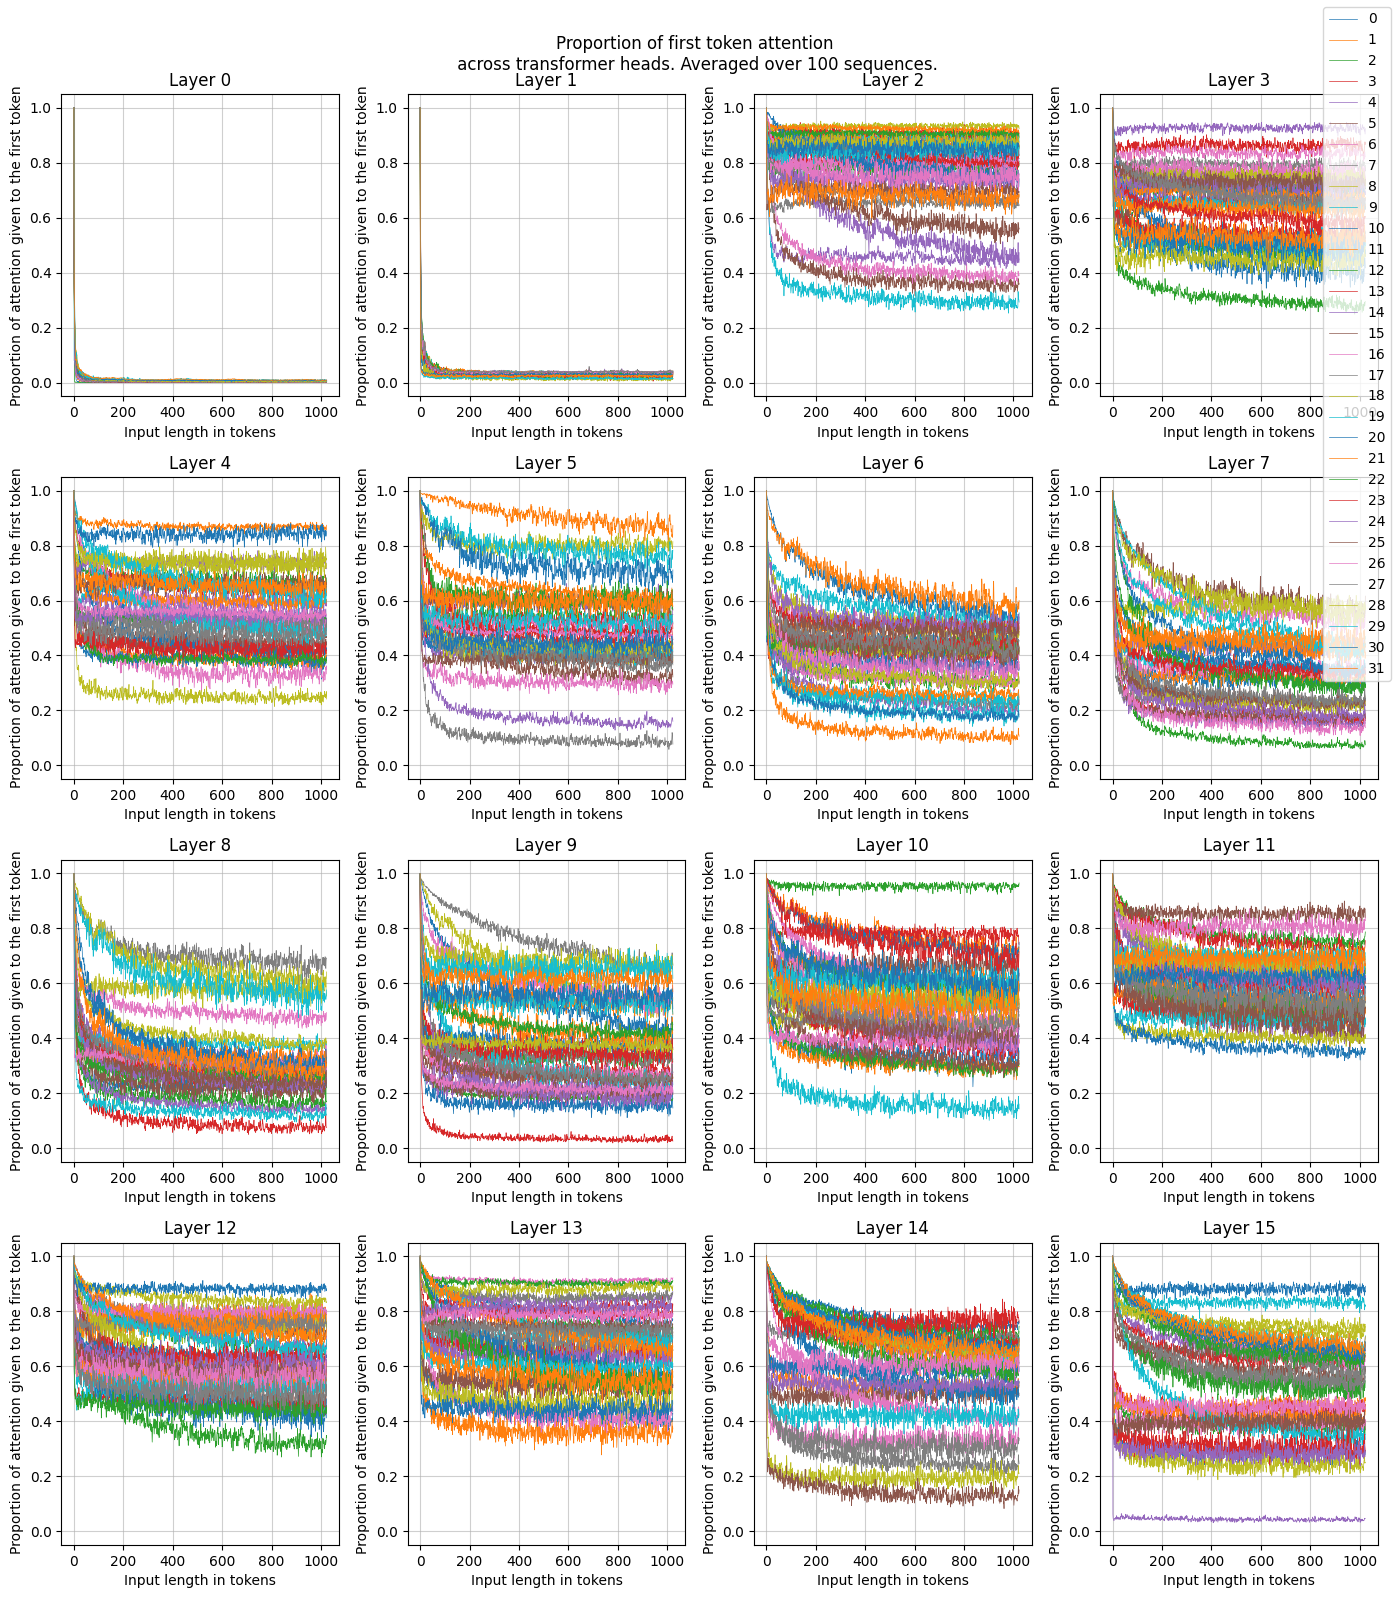

In [76]:
show_first_token_proportion(no_bos_attention_outputs_100)

### Experiment: Adding and removing sink tokens

Although massive activations appear only at the initial token int Llama3.2-1B, a lot of attention is given to punctuation tokens with less semantic meaning. Hence, we suspect that removing them will result in a more significant change in model's behaviour compared to removing random tokens.  

In [ ]:
# prompt = "We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely."
prompt = """The dominant sequence, transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English- to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data."""

inputs = llama3_tokenizer(
    prompt,
    return_tensors="pt",
).to(device)

In [98]:
def remove_random_tokens(token_ids: list[int], num_to_replace: int) -> list[int]:
    token_ids = torch.tensor(token_ids)
    idx_to_remove = torch.randperm(len(token_ids))[
        : min(num_to_replace, len(token_ids))
    ].tolist()

    mask = torch.ones(len(token_ids))
    mask[idx_to_remove] = False
    return token_ids[mask.bool()].tolist()

In [99]:
def remove_removable_tokens(token_ids: list[int], num_to_replace: int) -> list[int]:
    token_ids = torch.tensor(token_ids)
    removable_token_ids = [
        (13, "."),
        (11, ","),
        (279, " the"),
        (323, " and"),
        (220, " "),
        # (315, " of"),
        # (304, " in"),
        # (311, " to"),
        # (578, " The"),
        # (574, " was"),
        # (505, " from"),
        # (555, " by"),
        # (369, " for"),
        # (320, " ("),
        # (449, " with"),
        # (264, " a"),
    ]

    removable_idx = []
    for i, token_id in enumerate(token_ids):
        for removable_token_id, _ in removable_token_ids:
            if token_id == removable_token_id:
                removable_idx.append(i)

    # if num_to_replace is -1, remove all removable tokens
    if num_to_replace == -1:
        idx_to_remove = torch.tensor(removable_idx).tolist()
    else:
        idx_to_remove = torch.tensor(removable_idx)[
            torch.randperm(len(removable_idx))[
                : min(num_to_replace, len(removable_idx))
            ]
        ].tolist()

    mask = torch.ones(len(token_ids))
    mask[idx_to_remove] = False
    return token_ids[mask.bool()].tolist()

In [109]:
removed_input_ids_random = remove_random_tokens(inputs.input_ids[0].tolist(), 10)

In [110]:
removed_input_ids = remove_removable_tokens(inputs.input_ids[0].tolist(), -1)

In [111]:
print(prompt)
print(llama3_tokenizer.decode(removed_input_ids[1:]))
print(llama3_tokenizer.decode(removed_input_ids_random[1:]))

The dominant sequence, transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English- to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Trans